In [1]:
import tsai.all
import datetime
import pandas as pd
import torch
import numpy as np
import wandb
from fastai.callback.wandb import WandbCallback
from fastai.callback.tracker import EarlyStoppingCallback, SaveModelCallback
import time
import math

TSAI's Resnet doesn't take any hyperparameters so Sweeps will be run only to find the optimal batch size and number of epochs

In [2]:
%run ../../shared_functions.py
%run ../../my_shared_functions.py

<Figure size 640x480 with 0 Axes>

In [3]:
DIR_INPUT = '../../../fraud-detection-handbook/simulated-data-transformed/data/'

BEGIN_DATE = "2018-06-11"
END_DATE = "2018-09-14"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

output_feature="TX_FRAUD"

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']

Load  files
CPU times: total: 531 ms
Wall time: 4.9 s
919767 transactions loaded, containing 8195 fraudulent transactions


In [4]:
BEGIN_DATE = "2018-08-08"
start_date_training = datetime.datetime.strptime(BEGIN_DATE, "%Y-%m-%d")
delta_train=7
delta_delay=7
delta_test=7

delta_valid = delta_test

(train_df, valid_df)=get_train_test_set(transactions_df,start_date_training,
                                       delta_train=delta_train,delta_delay=delta_delay,delta_test=delta_test)

SEQ_LEN = 5

In [5]:
SEED = 42

if torch.cuda.is_available():
    DEVICE = "cuda" 
else:
    DEVICE = "cpu"
print("Selected device is",DEVICE)

seed_everything(SEED)

Selected device is cuda


In [6]:
(train_df, valid_df)=scaleData(train_df, valid_df,input_features)
x_train, y_train = prepare_sequenced_X_y(train_df, SEQ_LEN, input_features, output_feature)
x_valid, y_valid = prepare_sequenced_X_y(valid_df, SEQ_LEN, input_features, output_feature)
X, y, splits = tsai.all.combine_split_data([x_train.numpy(), x_valid.numpy()], [y_train.numpy(), y_valid.numpy()])

### Default

In [7]:
config = dict(
    dataset_id = 'fraud-detection-handbook-transformed',
    validation = 'train test split',
    seed = SEED,
    begin_date = BEGIN_DATE,
    delta_train = delta_train,
    delta_delay = delta_delay,
    delta_test = delta_test,
    batch_size=64,
    num_workers=0,
    early_stopping=True,
    early_stopping_patience=2,
    max_epochs=100,
    scale=True,
    criterion='bce',
    one_cycle_policy=True
)
wandb.init(project="mgr-anomaly-tsxai-project", config=config, tags=['resnet', 'tsai', 'imbalance-not-considered'])
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: chamera (mgr-anomaly-tsxai). Use `wandb login --relogin` to force relogin


In [8]:
dsets = tsai.all.TSDatasets(X, y, splits=splits, inplace=True)
dls = tsai.all.TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=config.batch_size, num_workers=config.num_workers, drop_last=False, device=DEVICE)
model = tsai.all.ResNet(
    c_in=dls.vars, 
    c_out=dls.c)

In [9]:
criterion = tsai.all.BCEWithLogitsLossFlat()
learn = tsai.all.ts_learner(
    dls,
    model,
    loss_func=criterion,
    opt_func=tsai.all.Adam,
    device=DEVICE,
    metrics=[],
    model_dir='ResNet',
    cbs=[
        WandbCallback(
            log='all',
            log_model=True,
            seed=config.seed),
        EarlyStoppingCallback(
            patience=config.early_stopping_patience
        ),
        SaveModelCallback(
            fname='resnet_fit_one_cycle'
        )])

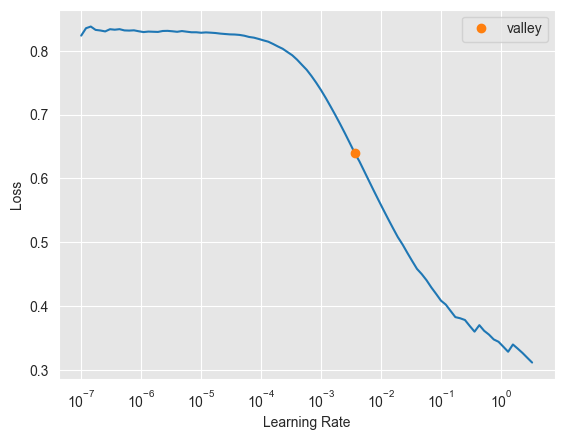

In [10]:
lr = learn.lr_find().valley
wandb.config.update({"lr": lr})

In [11]:
start_time=time.time()
learn.fit_one_cycle(config.max_epochs, lr)
training_execution_time=time.time()-start_time

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.026584,0.022157,00:28
1,0.018514,0.020401,00:31
2,0.017917,0.021324,00:30
3,0.018968,0.021286,00:31


Better model found at epoch 0 with valid_loss value: 0.02215726301074028.
Better model found at epoch 1 with valid_loss value: 0.020400645211338997.
No improvement since epoch 1: early stopping


In [12]:
start_time=time.time()
valid_predictions_logits = get_predictions_sequential(learn.model.cuda(), dls.valid)
prediction_execution_time=time.time()-start_time
predictions_df = valid_df
predictions_df['predictions'] = torch.nn.Sigmoid()(torch.FloatTensor(valid_predictions_logits)).numpy()
    
performance_df = performance_assessment_f1_included(predictions_df, top_k_list=[100])
performance_df

,AUC ROC,Average precision,F1 score,Card Precision@100
0,0.882,0.614,0.622,0.293


In [13]:
wandb.log({'Training execution time': training_execution_time})
wandb.log({'Prediction execution time': prediction_execution_time})
wandb.log({'AUC ROC': performance_df.loc[0,'AUC ROC']})
wandb.log({'Average precision': performance_df.loc[0,'Average precision']})
wandb.log({'F1 score': performance_df.loc[0,'F1 score']})
wandb.log({'Card Precision@100': performance_df.loc[0,'Card Precision@100']})
wandb.finish()

AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇██
mom_0,███████████▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▂▂▂▁▁
raw_loss,█▄▂▆▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▅▁▄▁█▅▂▁▁▁▁▁▁▅▁▁▁


### Sweeps

In [7]:
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train=7
delta_delay=7
delta_test=7
delta_valid = delta_test

n_folds=4

start_date_training_for_valid = start_date_training+datetime.timedelta(days=-(delta_delay+delta_valid))
start_date_training_for_test = start_date_training+datetime.timedelta(days=(n_folds-1)*delta_test)
delta_assessment = delta_valid

In [8]:
SEED = 42
seed_everything(SEED)

prequential_split = []
        
for fold in range(n_folds):
    start_date_training_fold = start_date_training-datetime.timedelta(days=fold*delta_assessment)
    
    (train_df, test_df)=get_train_test_set(transactions_df,
                                            start_date_training=start_date_training_fold,
                                            delta_train=delta_train,delta_delay=delta_delay,delta_test=delta_assessment)
    
    prequential_split.append((train_df, test_df))

In [9]:
SEQ_LEN = 5
if torch.cuda.is_available():
    DEVICE = "cuda" 
else:
    DEVICE = "cpu"
print("Selected device is",DEVICE)

Selected device is cuda


In [10]:
sweep_config = {
                'method': 'random', 
                'metric': {
                    'goal': 'minimize',
                    'name': 'val_loss'
                    },
                'parameters': {
                    'one_cycle_policy' : {
                        'value' : True
                    },
                    'batch_size': {
                        'values' : [64, 128, 256]
                    },
                    'max_epochs': {
                        'values': [1, 2, 3, 4, 5, 6, 7, 8]
                    },
                    'num_workers': {
                        'value' : 0
                    },
                    'seed': {
                        'value' : SEED
                    }
                }
 }

In [11]:
sweep_id = wandb.sweep(sweep_config, project="mgr-anomaly-tsxai-project")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: botwlxuf
Sweep URL: https://wandb.ai/mgr-anomaly-tsxai/mgr-anomaly-tsxai-project/sweeps/botwlxuf


In [14]:
def train(config=None):
    with wandb.init(project="mgr-anomaly-tsxai-project", config=config, tags=['resnet', 'tsai', 'imbalance-not-considered', 'sweeps']):
        config = wandb.config
        training_execution_times = []
        prediction_execution_times = []
        aucs = []
        average_precisions = []
        f1_scores = []
        card_precisions = []
        for i in range(n_folds):
            train_df = prequential_split[i][0]
            valid_df = prequential_split[i][1]
            (train_df, valid_df)=scaleData(train_df, valid_df,input_features)
            x_train, y_train = prepare_sequenced_X_y(train_df, SEQ_LEN, input_features, output_feature)
            x_valid, y_valid = prepare_sequenced_X_y(valid_df, SEQ_LEN, input_features, output_feature)
            X, y, tsai_splits = tsai.all.combine_split_data([x_train.numpy(), x_valid.numpy()], [y_train.numpy(), y_valid.numpy()])
            dsets = tsai.all.TSDatasets(X, y, splits=tsai_splits, inplace=True)
            dls = tsai.all.TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=config.batch_size, num_workers=config.num_workers, device=DEVICE, drop_last=False, batch_tfms=tsai.all.TSStandardize(by_var=True))
            
            model = tsai.all.ResNet(
                c_in=dls.vars, 
                c_out=dls.c)
            
            criterion = tsai.all.BCEWithLogitsLossFlat()
            learn = tsai.all.ts_learner(
                dls,
                model,
                loss_func=criterion,
                opt_func=tsai.all.Adam,
                device=DEVICE,
                metrics=[],
                model_dir='ResNet',
                cbs=[
                    WandbCallback(
                        log=None,
                        log_model=False,
                        seed=config.seed)])

            valley = learn.lr_find().valley

            start_time=time.time()
            learn.fit_one_cycle(config.max_epochs, valley)
            training_execution_times.append(time.time()-start_time)

            start_time=time.time()
            valid_predictions_logits = get_predictions_sequential(learn.model.cuda(), dls.valid)
            prediction_execution_times.append(time.time()-start_time)
            predictions_df = valid_df
            predictions_df['predictions'] = torch.nn.Sigmoid()(torch.FloatTensor(valid_predictions_logits)).numpy()
                
            performance_df = performance_assessment_f1_included(predictions_df, top_k_list=[100])
            aucs.append(performance_df.loc[0,'AUC ROC'])
            average_precisions.append(performance_df.loc[0,'Average precision'])
            f1_scores.append(performance_df.loc[0,'F1 score'])
            card_precisions.append(performance_df.loc[0,'Card Precision@100'])

        wandb.log({'Training execution time': np.sum(training_execution_times) / n_folds})
        wandb.log({'Prediction execution time': np.sum(prediction_execution_times) / n_folds})
        wandb.log({'AUC ROC': np.sum(aucs) / n_folds})
        wandb.log({'Average precision': np.sum(average_precisions) / n_folds})
        wandb.log({'F1 score': np.sum(f1_scores) / n_folds})
        wandb.log({'Card Precision@100': np.sum(card_precisions) / n_folds})

wandb: Agent Starting Run: 1ypx2nq7 with config:
wandb: 	batch_size: 64
wandb: 	max_epochs: 4
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: chamera (mgr-anomaly-tsxai). Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.024338,0.021949,00:30
1,0.021382,0.019031,00:31
2,0.018343,0.018109,00:32
3,0.013783,0.018170,00:33


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.025933,0.023720,00:34
1,0.019988,0.021902,00:33
2,0.021072,0.020121,00:33
3,0.015517,0.019588,00:33


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.021258,0.022104,00:33
1,0.022821,0.019830,00:34
2,0.019106,0.018832,00:33
3,0.018101,0.018184,00:33


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.032320,0.023972,00:33
1,0.027336,0.024161,00:33
2,0.019499,0.017177,00:33
3,0.034772,0.017817,00:34


AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▂▃▅▅▅▄▃▂▁▁▁▅▇▇▆▅▄▃▂▁▁▄▇▇▆▅▄▂▂▁▂▄██▇▆▄▃▂▁
mom_0,▇▅▁▁▂▃▄▆▇██▃▁▁▂▃▅▆▇██▄▁▁▂▄▅▆▇█▇▅▁▁▂▃▅▆▇█
raw_loss,▂▂▁▅▁█▇▁▆▅▂▄▁▆▁▇▁▁▁▆▅▆▆▁▁▁▆▁▁▁▅▁▂▂▁▂▁▁▁▁


wandb: Agent Starting Run: cz0k2csg with config:
wandb: 	batch_size: 256
wandb: 	max_epochs: 7
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.041788,0.023170,00:09
1,0.023335,0.020962,00:08
2,0.021490,0.019042,00:09
3,0.017748,0.018385,00:09
4,0.012606,0.019073,00:09
5,0.010862,0.019593,00:09
6,0.011799,0.020193,00:09


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.026829,0.021672,00:09
1,0.018294,0.021479,00:09
2,0.026195,0.021383,00:08
3,0.030885,0.019580,00:08
4,0.014037,0.018582,00:08
5,0.011892,0.019278,00:09
6,0.009645,0.019476,00:09


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.043173,0.024851,00:09
1,0.027615,0.020043,00:09
2,0.022733,0.019190,00:08
3,0.020783,0.018218,00:08
4,0.015819,0.019589,00:08
5,0.010644,0.021757,00:08
6,0.007115,0.022228,00:08


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.032319,0.020599,00:08
1,0.022457,0.017748,00:08
2,0.017023,0.018086,00:08
3,0.017706,0.016867,00:09
4,0.014710,0.016801,00:09
5,0.011269,0.018349,00:08
6,0.007393,0.019377,00:08


AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▄▄▄▃▃▂▁▁▁▄██▇▆▄▃▂▁▁▃▄▄▄▃▃▂▁▁▁▄▇▇▆▅▄▂▁▁
mom_0,█▅▁▁▂▃▄▆▇██▅▁▁▂▃▅▆▇██▅▁▁▂▃▅▆▇██▄▁▁▂▃▅▆██
raw_loss,▅▂▁▁▁▂▁▁▁▁▇▂▁▂▁▁▁▁▂▁█▂▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▂▂▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hhgn1qv9 with config:
wandb: 	batch_size: 256
wandb: 	max_epochs: 6
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.046363,0.027030,00:08
1,0.024125,0.019446,00:08
2,0.019424,0.018529,00:08
3,0.016866,0.018839,00:08
4,0.012521,0.019840,00:08
5,0.010945,0.019782,00:08


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.038725,0.028070,00:08
1,0.020796,0.023376,00:07
2,0.020199,0.021253,00:08
3,0.015906,0.019857,00:08
4,0.011307,0.020785,00:08
5,0.006799,0.021669,00:08


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.047988,0.024871,00:08
1,0.027541,0.019135,00:08
2,0.019956,0.017942,00:08
3,0.019425,0.017332,00:08
4,0.014792,0.018287,00:08
5,0.010812,0.018863,00:08


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.036095,0.019527,00:08
1,0.022940,0.018084,00:08
2,0.020841,0.019090,00:08
3,0.014180,0.017211,00:08
4,0.012535,0.017687,00:08
5,0.010874,0.018067,00:08


AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▃▄▄▄▃▃▂▁▁▁▃▅▅▅▄▃▂▁▁▁▄▆▆▅▄▃▂▁▁▂▆██▇▅▄▂▂▁
mom_0,█▅▂▁▂▃▄▆▇██▄▁▁▂▃▄▆▇██▃▁▁▂▄▅▆▇█▇▃▁▁▂▄▅▇▇█
raw_loss,▅▂▁▁▂▁▁▁▁▂█▁▂▂▁▂▁▁▁▁▆▂▁▁▂▁▁▂▁▁▃▁▁▂▁▁▁▁▁▁


wandb: Agent Starting Run: ajmv5dx1 with config:
wandb: 	batch_size: 256
wandb: 	max_epochs: 5
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.037443,0.023045,00:07
1,0.022162,0.020122,00:07
2,0.022087,0.019815,00:08
3,0.016485,0.018912,00:07
4,0.013924,0.018764,00:08


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.039756,0.024942,00:08
1,0.021891,0.020613,00:08
2,0.019796,0.019229,00:08
3,0.015812,0.018827,00:08
4,0.011125,0.019338,00:07


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.035046,0.022344,00:08
1,0.026416,0.024085,00:08
2,0.019159,0.019034,00:08
3,0.019035,0.017884,00:08
4,0.018512,0.017841,00:08


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.031569,0.020013,00:08
1,0.021163,0.017443,00:07
2,0.020597,0.018032,00:08
3,0.012571,0.016911,00:07
4,0.013903,0.017729,00:08


AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▂▅▇▇▆▅▄▃▂▁▁▃▆▆▅▅▄▃▂▁▂▅██▇▆▄▃▂▁▁▄▇▇▆▅▄▃▂▁
mom_0,▇▄▁▁▂▃▅▆▇██▅▁▁▂▃▄▆▇█▇▄▁▁▂▃▅▆▇██▅▁▁▂▃▄▆▇█
raw_loss,▄▁▂▁▁▁▁▁▁▂█▂▁▁▁▁▁▁▁▁▃▁▂▂▁▁▁▁▁▂▅▁▂▂▁▁▁▁▁▁


wandb: Agent Starting Run: q2824x5h with config:
wandb: 	batch_size: 64
wandb: 	max_epochs: 4
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.022694,0.020513,00:32
1,0.027761,0.018828,00:32
2,0.017703,0.018766,00:32
3,0.020806,0.018138,00:32


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.019538,0.021880,00:32
1,0.019626,0.019138,00:32
2,0.012693,0.018938,00:32
3,0.017095,0.018699,00:32


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.026650,0.022699,00:32
1,0.024525,0.020627,00:32
2,0.023134,0.020019,00:34
3,0.021006,0.017864,00:35


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.035503,0.022608,00:35
1,0.025633,0.018136,00:35
2,0.021752,0.016818,00:34
3,0.021117,0.016313,00:35


AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▂▄▇▇▆▅▄▃▂▁▁▅▇▇▆▅▄▃▂▁▁▄▇▇▆▅▄▂▂▁▂▄██▇▆▄▃▂▁
mom_0,▇▅▁▁▂▃▄▆▇██▃▁▁▂▃▅▆▇██▄▁▁▂▄▅▆▇█▇▅▁▁▂▃▅▆▇█
raw_loss,▁▃▁▃▁▁▄▁▁▂▂▁▁▁▃▁▁▁▁▁█▃▁▁▄▁▁▁▁▁▁▁▄▃▂▂▄▁▁▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1lttqpt2 with config:
wandb: 	batch_size: 128
wandb: 	max_epochs: 8
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.025841,0.023824,00:16
1,0.025652,0.021147,00:17
2,0.023586,0.018595,00:17
3,0.021184,0.018433,00:17
4,0.015199,0.018703,00:18
5,0.012145,0.019033,00:17
6,0.011683,0.020000,00:17
7,0.010856,0.019617,00:18


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.029660,0.024007,00:17
1,0.019124,0.023188,00:17
2,0.013044,0.022123,00:17
3,0.020068,0.019545,00:17
4,0.013162,0.019400,00:17
5,0.010130,0.021012,00:17
6,0.008288,0.023164,00:17
7,0.003848,0.023811,00:17


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.027646,0.022273,00:17
1,0.025343,0.019188,00:17
2,0.020813,0.018533,00:17
3,0.017723,0.019078,00:17
4,0.021557,0.018785,00:17
5,0.016789,0.017535,00:17
6,0.014969,0.018894,00:17
7,0.012298,0.019198,00:17


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.025935,0.018197,00:18
1,0.021310,0.018186,00:17
2,0.019500,0.019590,00:17
3,0.021222,0.017041,00:18
4,0.018078,0.016275,00:17
5,0.009998,0.017999,00:17
6,0.011839,0.018307,00:17
7,0.008663,0.018708,00:17


AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▂▃▅▅▄▄▃▂▁▁▁▃▄▄▄▃▂▂▁▁▁▅██▇▅▄▃▂▁▂▄▇▇▆▅▃▃▂▁
mom_0,▇▅▁▁▂▃▄▆▇██▃▁▁▂▃▅▆▇██▄▁▁▂▄▅▆▇█▇▅▁▁▂▃▅▆▇█
raw_loss,▆▁▁▁▅▁▁▁▁▃█▄▁▂▂▆▁▃▁▁█▂▁▁▃▁▁▁▂▁▂▂▂▁▁▁█▁▁▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qglr71xs with config:
wandb: 	batch_size: 64
wandb: 	max_epochs: 7
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.029064,0.023132,00:33
1,0.027765,0.019772,00:33
2,0.017070,0.021707,00:33
3,0.019489,0.018111,00:33
4,0.018333,0.019042,00:33
5,0.016357,0.018496,00:34
6,0.014121,0.019149,00:33


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.022877,0.021815,00:33
1,0.022119,0.023151,00:33
2,0.019421,0.018953,00:33
3,0.022037,0.020424,00:34
4,0.012847,0.018881,00:33
5,0.014368,0.019299,00:33
6,0.012127,0.019638,00:33


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.032460,0.021208,00:33
1,0.021880,0.021333,00:34
2,0.023983,0.019396,00:34
3,0.018809,0.018668,00:33
4,0.018790,0.018134,00:33
5,0.016856,0.018468,00:33
6,0.012584,0.018318,00:33


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.023912,0.018827,00:33
1,0.019014,0.020159,00:33
2,0.018933,0.016418,00:33
3,0.019018,0.017741,00:34
4,0.023123,0.017235,00:35
5,0.014957,0.017019,00:34
6,0.010459,0.017208,00:33


AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▂▄██▇▆▅▃▂▁▁▃▆▆▅▄▃▂▁▁▁▅██▇▆▄▃▂▁▁▄▆▆▅▄▃▂▁▁
mom_0,█▅▁▁▂▃▅▆▇██▅▁▁▂▃▅▆▇██▄▁▁▂▃▅▆▇██▄▁▁▂▄▅▇██
raw_loss,▁▁▁▁▂▁▁▁▁▁▇▁▅▁▁▁▁▁▁▁▄▁▁▂▁▁▄█▂▁▂▁▁▁▁▁▁▁▁▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sk9mufdq with config:
wandb: 	batch_size: 256
wandb: 	max_epochs: 6
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.035208,0.023086,00:08
1,0.021741,0.021370,00:08
2,0.021159,0.018943,00:08
3,0.017549,0.018984,00:08
4,0.014216,0.019141,00:08
5,0.010562,0.019333,00:09


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.033964,0.028096,00:08
1,0.022197,0.021027,00:09
2,0.019953,0.019400,00:09
3,0.014463,0.019189,00:09
4,0.012955,0.019297,00:09
5,0.008152,0.019903,00:08


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.028850,0.022899,00:08
1,0.024854,0.023074,00:08
2,0.021762,0.019355,00:08
3,0.018783,0.019092,00:08
4,0.015838,0.019148,00:08
5,0.013516,0.019677,00:08


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.038721,0.019926,00:08
1,0.024859,0.016889,00:08
2,0.018506,0.019144,00:08
3,0.015103,0.016959,00:08
4,0.013964,0.017315,00:09
5,0.008727,0.018010,00:08


AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▃▅▅▅▄▃▂▂▁▁▄▆▆▅▄▃▂▂▁▂▆██▇▅▄▃▂▁▂▄▅▅▄▃▃▂▁▁
mom_0,█▅▂▁▂▃▄▆▇██▄▁▁▂▃▄▆▇██▃▁▁▂▄▅▆▇█▇▃▁▁▂▄▅▇▇█
raw_loss,▃▂▂▂▁▂▁▁▁▁█▁▂▁▁▁▁▁▁▁▂▁▂▁▁▁▂▁▁▁▂▁▂▁▁▁▁▁▁▁


wandb: Agent Starting Run: ojd0tnxx with config:
wandb: 	batch_size: 64
wandb: 	max_epochs: 3
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.036252,0.022271,00:32
1,0.019261,0.019366,00:32
2,0.016419,0.017880,00:32


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.021731,0.023827,00:32
1,0.019100,0.021542,00:32
2,0.017363,0.020179,00:32


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.025353,0.021277,00:32
1,0.022468,0.021754,00:32
2,0.017207,0.018319,00:32


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.030481,0.023834,00:32
1,0.023322,0.018986,00:32
2,0.017357,0.016610,00:32


AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▄▄▄▃▂▂▁▁▁▃▄▄▄▃▃▂▁▁▁▄▅▅▄▄▃▂▁▁▂▇█▇▇▅▄▂▂▁
mom_0,█▅▂▁▂▃▄▆▇██▄▁▁▂▃▅▆▇██▃▁▁▂▄▅▆▇█▇▂▁▂▂▄▅▇▇█
raw_loss,▅▁▁▁▁▁▅▁▁▁█▁▁▁▃▁▁▁▁▂▃▆▁▁▄▁▁▂▁▁▃▁▁▁▁▁▁▁▁▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nv6ofejp with config:
wandb: 	batch_size: 128
wandb: 	max_epochs: 4
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.022994,0.021381,00:16
1,0.020839,0.018892,00:16
2,0.018835,0.018368,00:16
3,0.016395,0.018073,00:16


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.021874,0.023144,00:16
1,0.024313,0.020384,00:16
2,0.014758,0.019217,00:16
3,0.013105,0.019101,00:16


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.028237,0.022692,00:16
1,0.021176,0.019812,00:16
2,0.018180,0.017445,00:16
3,0.019344,0.017075,00:16


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.026894,0.019406,00:16
1,0.025332,0.019999,00:16
2,0.032561,0.016381,00:16
3,0.018608,0.016428,00:16


AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▂▃▅▅▅▄▃▂▁▁▁▃▄▄▄▃▃▂▁▁▁▄▇▇▆▅▄▂▂▁▂▄██▇▆▄▃▂▁
mom_0,▇▅▁▁▂▃▄▆▇██▃▁▁▂▃▅▆▇██▄▁▁▂▄▅▆▇█▇▅▁▁▂▃▅▆▇█
raw_loss,▂▁▁▂▁▂▁▁▁▁▃▂▁▁▁▁▁▃▁▂█▂▁▂▃▁▂▁▁▁▁▂▃▁▁▁▂▂▂▁


wandb: Agent Starting Run: qz0wmjb8 with config:
wandb: 	batch_size: 128
wandb: 	max_epochs: 2
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.021169,0.019657,00:16
1,0.015917,0.018052,00:16


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.020754,0.021269,00:16
1,0.020715,0.018790,00:16


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.024214,0.022698,00:16
1,0.017478,0.017664,00:16


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.024608,0.017278,00:16
1,0.017219,0.015987,00:16


AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▂▄▇▇▆▅▄▃▂▁▁▃▄▄▄▃▃▂▁▁▁▄▇▇▆▅▄▂▂▁▂▄██▇▆▄▃▂▁
mom_0,▇▅▁▁▂▃▄▆▇██▃▁▁▂▃▅▆▇██▄▁▁▂▄▅▆▇█▇▅▁▁▂▃▅▆▇█
raw_loss,▃▁▁▂▁▂▂▁▁▁█▂▁▁▁▁▁▁▂▂█▂▁▁▁▃▁▂▁▁▂▂▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: b1g2c51x with config:
wandb: 	batch_size: 256
wandb: 	max_epochs: 6
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.042020,0.025195,00:09
1,0.025456,0.020546,00:09
2,0.021138,0.020206,00:09
3,0.021410,0.019331,00:09
4,0.014574,0.019251,00:09
5,0.010414,0.020124,00:09


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.035839,0.024472,00:09
1,0.021177,0.021499,00:09
2,0.018770,0.020859,00:09
3,0.013204,0.021429,00:08
4,0.009597,0.021322,00:09
5,0.006499,0.022348,00:09


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.038769,0.025708,00:09
1,0.024015,0.019778,00:09
2,0.024472,0.019025,00:09
3,0.017860,0.018932,00:09
4,0.018444,0.017974,00:09
5,0.014684,0.018061,00:09


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.034393,0.021230,00:09
1,0.020353,0.019791,00:09
2,0.021903,0.018722,00:09
3,0.017842,0.017606,00:09
4,0.013649,0.017687,00:09
5,0.009431,0.018265,00:09


AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▃▅▆▅▄▄▂▂▁▁▃▅▅▅▄▃▂▁▁▂▆██▇▅▄▃▂▁▂▆██▇▅▄▂▂▁
mom_0,█▅▂▁▂▃▄▆▇██▄▁▁▂▃▄▆▇██▃▁▁▂▄▅▆▇█▇▃▁▁▂▄▅▇▇█
raw_loss,▅▂▁▂▁▁▁▁▁▁█▁▁▁▂▁▁▁▁▁▅▁▁▁▁▂▂▁▁▁▃▂▁▁▂▁▁▂▁▂


wandb: Agent Starting Run: zx7nw6bs with config:
wandb: 	batch_size: 128
wandb: 	max_epochs: 4
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.030252,0.022195,00:16
1,0.019902,0.019024,00:16
2,0.017936,0.018512,00:16
3,0.015009,0.018557,00:16


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.021971,0.023658,00:16
1,0.022635,0.020522,00:16
2,0.017785,0.019021,00:16
3,0.012875,0.018529,00:16


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.025278,0.020125,00:16
1,0.025473,0.019645,00:16
2,0.022604,0.017944,00:16
3,0.016573,0.017184,00:16


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.026057,0.020186,00:17
1,0.019445,0.016647,00:17
2,0.019882,0.016895,00:17
3,0.014019,0.016858,00:17


AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▄▄▃▃▂▂▁▁▁▃▄▄▄▃▃▂▁▁▁▅██▇▅▄▃▂▁▁▂▄▄▃▃▂▂▁▁
mom_0,▇▅▁▁▂▃▄▆▇██▃▁▁▂▃▅▆▇██▄▁▁▂▄▅▆▇█▇▅▁▁▂▃▅▆▇█
raw_loss,▂▁▃▁▁▁▁▁▂▁▅▃▁▁▃▃▂▁▁▁█▅▃▂▄▁▁▁▁▂▃▁▁▁▁▃▁▂▃▁


wandb: Agent Starting Run: q8sgnzak with config:
wandb: 	batch_size: 128
wandb: 	max_epochs: 3
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.022652,0.021118,00:16
1,0.020412,0.018789,00:16
2,0.022078,0.018256,00:16


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.024539,0.023300,00:16
1,0.020861,0.019260,00:16
2,0.016283,0.018171,00:16


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.026865,0.021425,00:16
1,0.019343,0.018722,00:16
2,0.015766,0.017513,00:16


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.028062,0.018936,00:16
1,0.018919,0.016358,00:16
2,0.013390,0.016288,00:16


AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▃▅▅▅▄▃▂▂▁▁▅██▇▆▅▃▂▁▁▅▆▆▅▄▃▂▁▁▂▄▅▅▄▃▃▂▁▁
mom_0,█▅▂▁▂▃▄▆▇██▄▁▁▂▃▅▆▇██▃▁▁▂▄▅▆▇█▇▂▁▁▂▄▅▇▇█
raw_loss,▃▁▁▁▁▂▁▂▁▁█▁▁▁▁▁▁▁▂▁▄▁▂▁▁▁▁▁▁▁▄▁▁▂▁▁▁▂▁▁


wandb: Agent Starting Run: dhg4wfl8 with config:
wandb: 	batch_size: 256
wandb: 	max_epochs: 3
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.034671,0.021491,00:08
1,0.021793,0.020162,00:08
2,0.018430,0.018455,00:08


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.030964,0.029095,00:08
1,0.018330,0.022313,00:08
2,0.013683,0.018829,00:08


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.035420,0.020597,00:08
1,0.023346,0.018312,00:08
2,0.018718,0.017755,00:08


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.029683,0.020423,00:08
1,0.022057,0.017229,00:08
2,0.015348,0.016487,00:08


AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▃▅▅▅▄▃▂▂▁▁▃▅▅▅▄▃▂▁▁▁▄▅▅▄▄▃▂▁▁▂▆██▇▅▄▂▂▁
mom_0,█▅▂▁▂▃▄▆▇██▄▁▁▂▃▄▆▇██▃▁▁▂▄▅▆▇█▇▃▁▁▂▄▅▇▇█
raw_loss,▆▂▁▁▁▁▁▁▁▁█▂▁▁▂▁▁▁▁▁█▁▁▂▁▂▁▁▁▁▃▂▂▁▁▁▂▁▁▁


wandb: Agent Starting Run: rjfhrloa with config:
wandb: 	batch_size: 256
wandb: 	max_epochs: 3
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.034023,0.021426,00:08
1,0.023143,0.019567,00:08
2,0.016557,0.018602,00:08


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.031596,0.023472,00:08
1,0.019645,0.019545,00:08
2,0.013946,0.018859,00:08


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.029780,0.022579,00:08
1,0.021083,0.017994,00:08
2,0.018761,0.017796,00:08


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.031754,0.020769,00:08
1,0.020211,0.019414,00:08
2,0.016522,0.015999,00:08


AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▃▄▄▄▃▃▂▁▁▁▄▆▆▅▄▃▂▂▁▂▆██▇▅▄▃▂▁▂▆██▇▅▄▂▂▁
mom_0,█▅▂▁▂▃▄▆▇██▄▁▁▂▃▄▆▇██▃▁▁▂▄▅▆▇█▇▃▁▁▂▄▅▇▇█
raw_loss,▅▂▂▁▁▁▁▁▁▁█▂▂▁▁▁▁▁▁▁▅▁▁▁▁▁▁▁▂▁▃▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: e6ynzyob with config:
wandb: 	batch_size: 64
wandb: 	max_epochs: 2
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.030046,0.025288,00:31
1,0.021478,0.017941,00:31


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.026212,0.021103,00:31
1,0.014001,0.018576,00:31


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.025195,0.021744,00:31
1,0.025237,0.018852,00:31


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.024984,0.017688,00:31
1,0.018184,0.016496,00:31


AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▂▄██▇▆▅▃▂▁▁▄▅▅▅▄▃▂▁▁▁▄▆▆▅▄▃▂▂▁▂▃▅▅▅▄▃▂▁▁
mom_0,▇▅▁▁▂▃▄▆▇██▃▁▁▂▃▅▆▇██▄▁▁▂▄▅▆▇█▇▅▁▁▂▃▅▆▇█
raw_loss,▂▄▁▁▄▁▁▂▁▁▇▂▁▅▁▁▁▁▁▄█▂▁▁▁▁▁▁▁▁▄▁▁▂▁▁▁▁▁▄


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: evini79v with config:
wandb: 	batch_size: 128
wandb: 	max_epochs: 6
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.022517,0.022353,00:16
1,0.023539,0.019967,00:16
2,0.022160,0.019656,00:16
3,0.018386,0.018476,00:16
4,0.013098,0.019019,00:16
5,0.014733,0.019149,00:16


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.024467,0.021407,00:17
1,0.019959,0.020304,00:17
2,0.016549,0.021101,00:17
3,0.017259,0.018725,00:17
4,0.010048,0.019297,00:17
5,0.010951,0.019343,00:15


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.028779,0.023149,00:15
1,0.022042,0.020957,00:15
2,0.025478,0.018419,00:15
3,0.018220,0.019270,00:15
4,0.012726,0.018738,00:15
5,0.010874,0.019459,00:15


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.023086,0.018606,00:15
1,0.023641,0.019410,00:15
2,0.014830,0.017284,00:15
3,0.020107,0.016178,00:15
4,0.013648,0.017254,00:15
5,0.013989,0.017854,00:15


AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▃▅▅▅▄▃▂▂▁▁▅██▇▆▅▃▂▁▁▃▄▄▃▃▂▂▁▁▂▅▆▆▅▄▃▂▁▁
mom_0,█▅▂▁▂▃▄▆▇██▄▁▁▂▃▅▆▇██▃▁▁▂▄▅▆▇█▇▂▁▁▂▄▅▇▇█
raw_loss,▄▃▁▁▁▂▂▁▃▁█▂▁▃▁▃▂▁▁▃▇▄▁▄▃▂▁▂▁▁▄▁▃▂▁▄▁▁▁▂


wandb: Agent Starting Run: zknyes46 with config:
wandb: 	batch_size: 64
wandb: 	max_epochs: 8
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.019432,0.022347,00:30
1,0.021536,0.022413,00:30
2,0.021719,0.018821,00:30
3,0.030615,0.019390,00:30
4,0.022204,0.019076,00:30
5,0.013708,0.018485,00:30
6,0.013917,0.019246,00:30
7,0.011875,0.019183,00:30


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.031025,0.022085,00:30
1,0.021525,0.021319,00:30
2,0.023169,0.019985,00:30
3,0.017404,0.020947,00:30
4,0.021368,0.019449,00:30
5,0.021270,0.019299,00:30
6,0.015713,0.019170,00:30
7,0.011715,0.019401,00:30


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.029392,0.021697,00:30
1,0.030625,0.022846,00:30
2,0.031735,0.023647,00:30
3,0.020111,0.018927,00:30
4,0.022022,0.020940,00:30
5,0.024254,0.018414,00:29
6,0.014266,0.017900,00:30
7,0.014716,0.017912,00:30


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.026826,0.017882,00:30
1,0.014697,0.017179,00:30
2,0.019728,0.016918,00:30
3,0.025757,0.016866,00:30
4,0.012052,0.017672,00:30
5,0.017649,0.016890,00:31
6,0.008423,0.018049,00:31
7,0.011378,0.017780,00:31


AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▂▃▄▄▄▃▃▂▁▁▁▅▇▇▆▅▄▃▂▁▁▅██▇▅▄▃▂▁▂▃▆▆▅▄▃▂▁▁
mom_0,▇▅▁▁▂▃▄▆▇██▃▁▁▂▃▅▆▇██▄▁▁▂▄▅▆▇█▇▅▁▁▂▃▅▆▇█
raw_loss,▁▃▁▁▁▁▁▁▁▁▂█▁▁▁▃▁▁▅▁▂▁▁▃▄▁▁▁▁▁▁▂▁▅▂▁▁▁▁▁


wandb: Agent Starting Run: 58m2iyj0 with config:
wandb: 	batch_size: 256
wandb: 	max_epochs: 8
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.030588,0.022646,00:07
1,0.025269,0.020171,00:08
2,0.021330,0.019100,00:08
3,0.020400,0.019006,00:08
4,0.016944,0.018851,00:08
5,0.013928,0.018434,00:08
6,0.011465,0.019882,00:08
7,0.008971,0.020205,00:08


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.033908,0.024602,00:08
1,0.023896,0.020829,00:08
2,0.020222,0.022288,00:08
3,0.017158,0.019119,00:08
4,0.015103,0.020943,00:08
5,0.011159,0.021181,00:08
6,0.006849,0.022888,00:08
7,0.005809,0.023621,00:08


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.043979,0.023773,00:08
1,0.021829,0.020283,00:08
2,0.024300,0.018506,00:08
3,0.017538,0.018538,00:08
4,0.018222,0.018993,00:08
5,0.015259,0.018855,00:08
6,0.009595,0.020641,00:08
7,0.007413,0.021671,00:08


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.038175,0.022609,00:08
1,0.024521,0.018628,00:08
2,0.022681,0.017772,00:08
3,0.020143,0.019776,00:08
4,0.015830,0.017523,00:08
5,0.014085,0.019157,00:08
6,0.009966,0.019440,00:08
7,0.006903,0.019783,00:08


AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▂▄██▇▆▅▃▂▁▁▄▆▆▅▄▃▃▂▁▁▃▅▅▄▄▃▂▂▁▂▃▇▇▆▅▃▃▂▁
mom_0,▇▅▁▁▂▃▄▆▇██▃▁▁▂▃▅▆▇██▄▁▁▂▄▄▆▇█▇▅▁▁▂▃▅▆▇█
raw_loss,▂▁▁▁▂▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▂▁▁▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dux43tkm with config:
wandb: 	batch_size: 256
wandb: 	max_epochs: 8
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.036871,0.023876,00:08
1,0.024766,0.021462,00:08
2,0.021445,0.018612,00:08
3,0.019906,0.018773,00:08
4,0.016758,0.019497,00:08
5,0.012899,0.019757,00:08
6,0.011050,0.021566,00:08
7,0.008397,0.022142,00:08


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.045737,0.029194,00:08
1,0.022620,0.024492,00:08
2,0.020819,0.019420,00:08
3,0.017072,0.019587,00:08
4,0.015330,0.019584,00:08
5,0.010901,0.021392,00:08
6,0.006990,0.022695,00:08
7,0.004672,0.022649,00:08


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.048290,0.024781,00:09
1,0.029056,0.022740,00:10
2,0.025734,0.018776,00:09
3,0.022191,0.019143,00:08
4,0.017108,0.017807,00:08
5,0.014598,0.018367,00:08
6,0.010613,0.020560,00:08
7,0.008190,0.020751,00:08


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.038348,0.020293,00:08
1,0.022623,0.018207,00:08
2,0.022009,0.018807,00:08
3,0.017234,0.018173,00:08
4,0.018312,0.017144,00:08
5,0.012082,0.017234,00:08
6,0.008781,0.019179,00:08
7,0.005538,0.020018,00:08


AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▂▄██▇▆▅▃▂▁▁▄▅▅▅▄▃▂▁▁▁▄▇▇▆▅▄▂▂▁▂▄██▇▆▄▃▂▁
mom_0,▇▅▁▁▂▃▄▆▇██▃▁▁▂▃▅▆▇██▄▁▁▂▄▄▆▇█▇▅▁▁▂▃▅▆▇█
raw_loss,▁▁▁▁▂▁▁▁▁▁▄▁▂▂▁▁▁▁▁▁█▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: q6qknnex with config:
wandb: 	batch_size: 256
wandb: 	max_epochs: 1
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.027600,0.020117,00:08


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.025659,0.021573,00:08


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.030035,0.021658,00:08


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.026965,0.018341,00:08


AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▂▄▇▇▆▅▄▃▂▁▁▃▄▄▄▃▃▂▁▁▁▃▄▄▄▃▃▂▂▁▂▄██▇▆▄▃▂▁
mom_0,▇▅▁▁▂▃▄▆▇██▃▁▁▂▃▅▆▇██▄▁▁▂▄▄▆▇█▇▅▁▁▂▃▅▆▇█
raw_loss,▄▂▁▁▁▁▂▁▁▁▆▂▁▁▁▁▁▁▁▁█▂▁▁▁▁▁▂▁▁▆▂▁▁▁▂▁▁▁▁


wandb: Agent Starting Run: gw2pldyq with config:
wandb: 	batch_size: 128
wandb: 	max_epochs: 1
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.022050,0.018696,00:16


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.023581,0.020732,00:16


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.020283,0.018824,00:16


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.019638,0.016441,00:16


AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▂▃▆▆▅▄▄▂▁▁▁▃▄▄▄▃▃▂▁▁▁▅██▇▅▅▃▂▁▂▄██▇▆▄▃▂▁
mom_0,▇▅▁▁▂▃▄▆▇██▃▁▁▂▃▅▆▇██▄▁▁▂▄▄▆▇█▇▅▁▁▂▃▅▆▇█
raw_loss,▃▂▁▁▁▁▁▁▁▁█▂▁▁▁▁▁▁▂▁▆▁▁▁▂▁▁▁▁▁▃▂▁▁▁▁▁▁▁▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rvdy606n with config:
wandb: 	batch_size: 64
wandb: 	max_epochs: 3
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	seed: 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.015970,0.022781,00:38
1,0.019324,0.018820,00:37
2,0.021806,0.017738,00:37


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.027822,0.021775,00:36
1,0.020642,0.019702,00:35
2,0.021007,0.019708,00:35


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.037143,0.021840,00:35
1,0.027523,0.020094,00:35
2,0.018396,0.018530,00:34


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


epoch,train_loss,valid_loss,time
0,0.035573,0.019610,00:35
1,0.017138,0.017592,00:36
2,0.016057,0.016855,00:36


AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▃▅▅▅▄▃▂▂▁▁▅██▇▆▄▃▂▁▁▄▅▅▄▄▃▂▁▁▂▇█▇▇▅▄▂▂▁
mom_0,█▅▂▁▂▃▄▆▇██▄▁▁▂▃▅▆▇██▃▁▁▂▄▅▆▇█▇▂▁▂▂▄▅▇▇█
raw_loss,▅▄▂▁▄▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▅▄▁▂▆▁▃▁▁▁▂▁▅▄▁▁▁▁▂▄


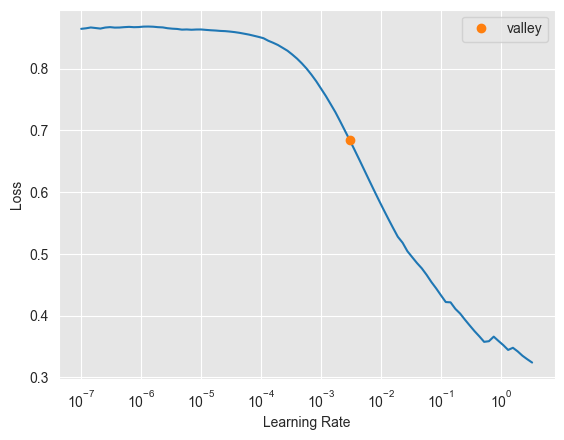

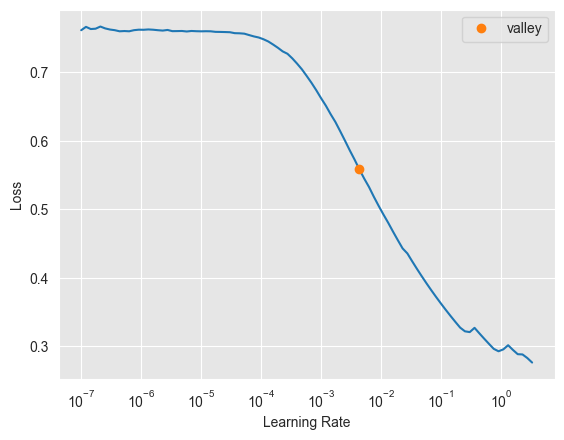

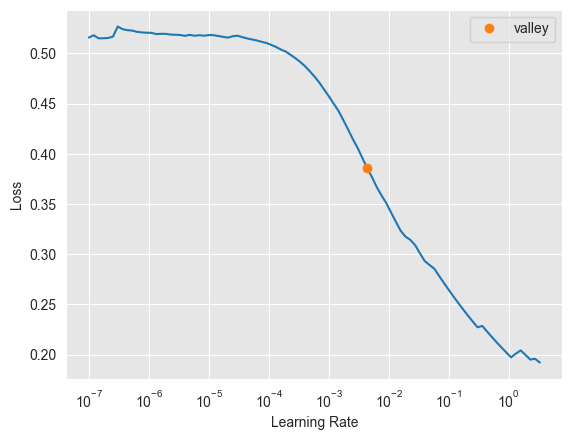

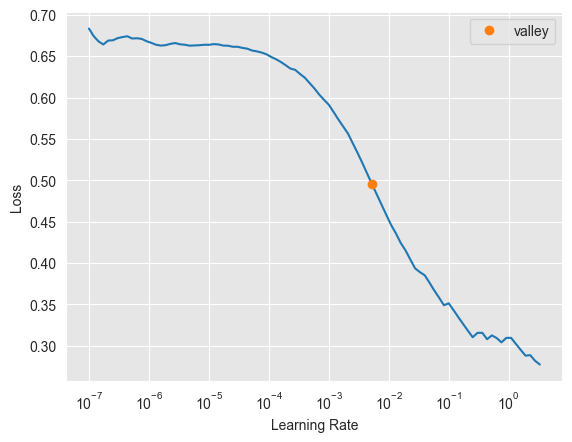

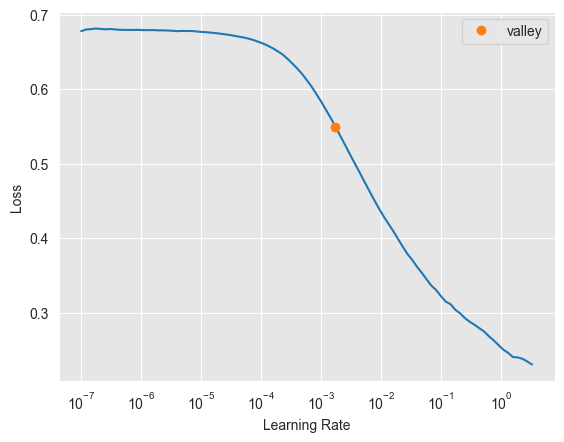

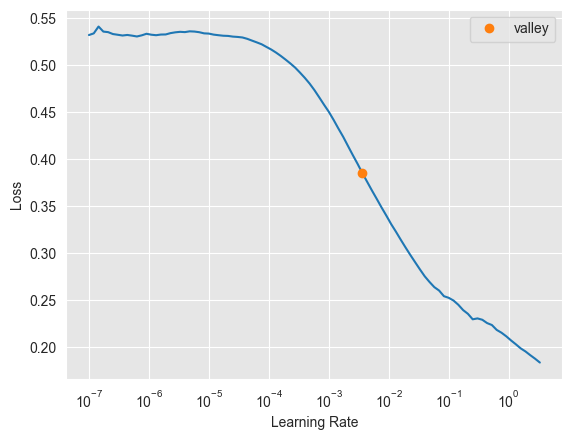

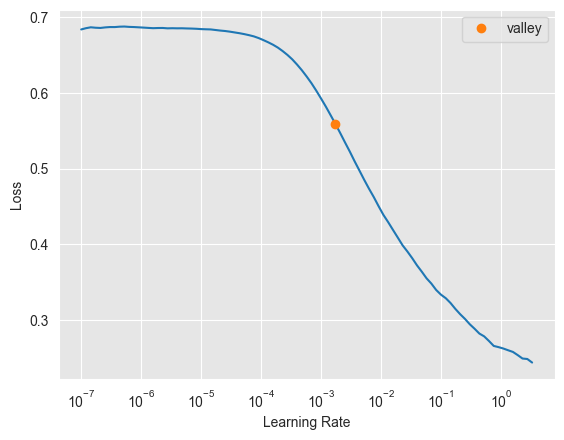

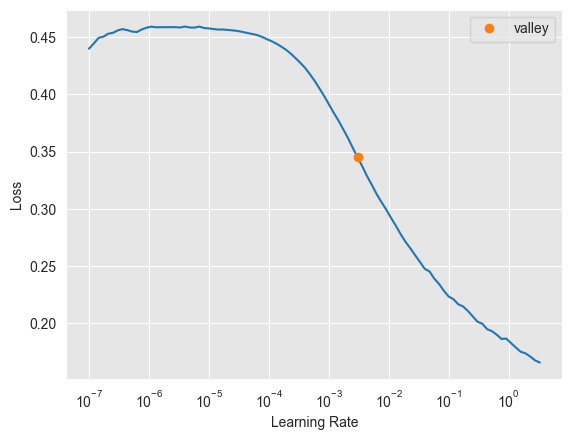

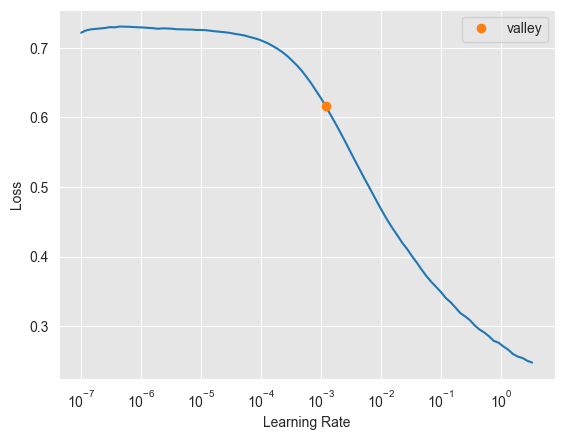

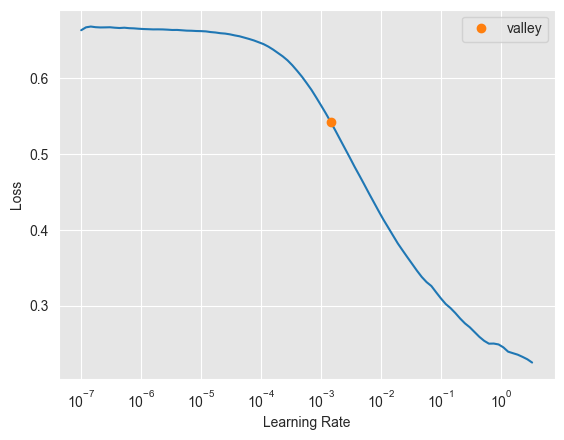

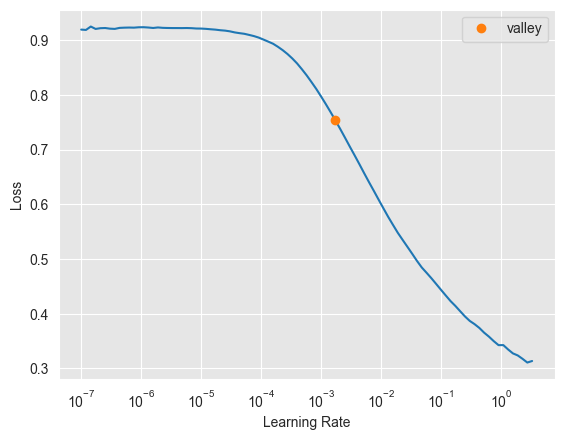

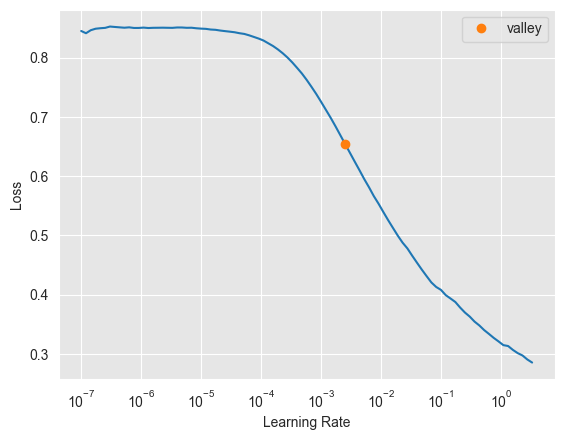

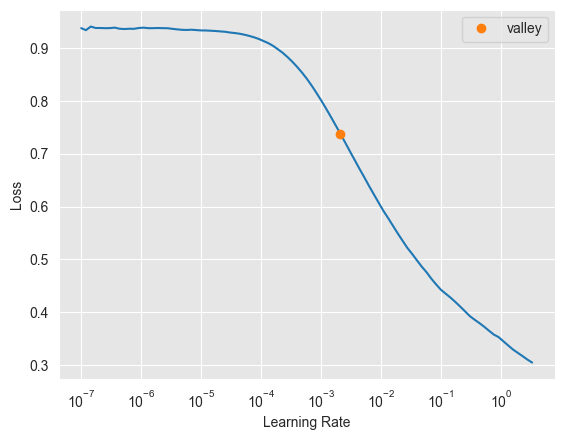

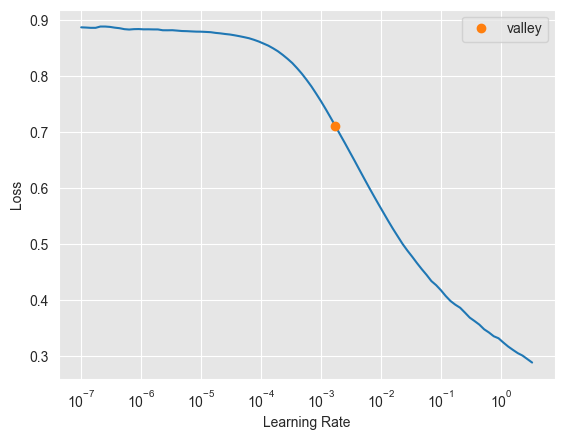

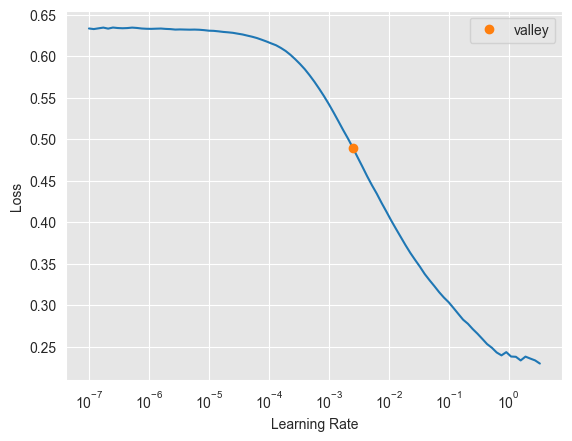

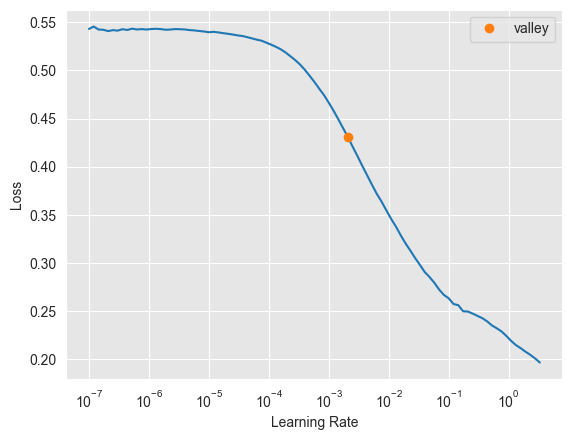

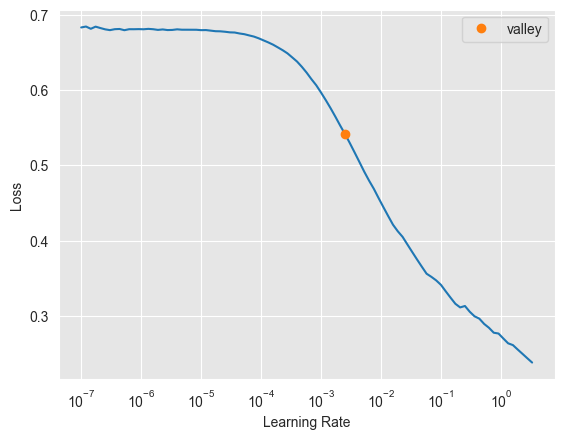

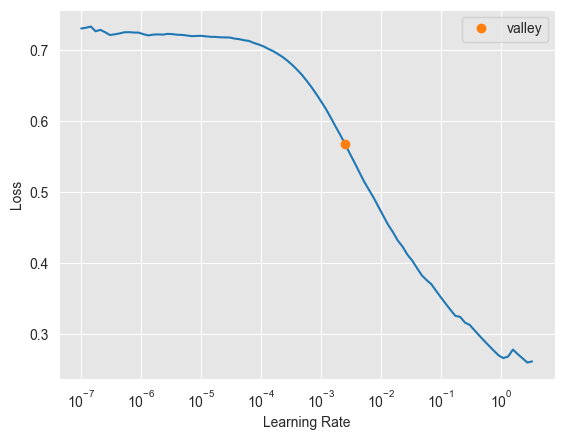

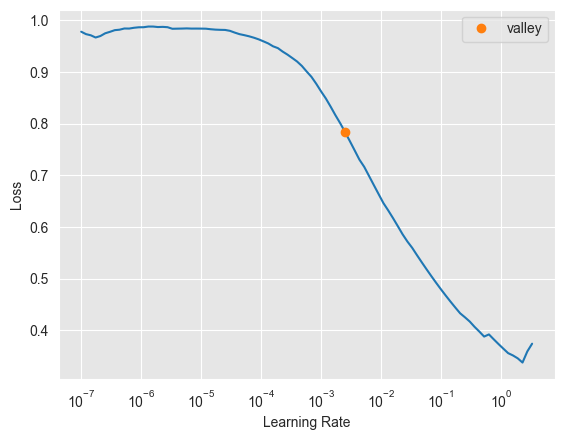

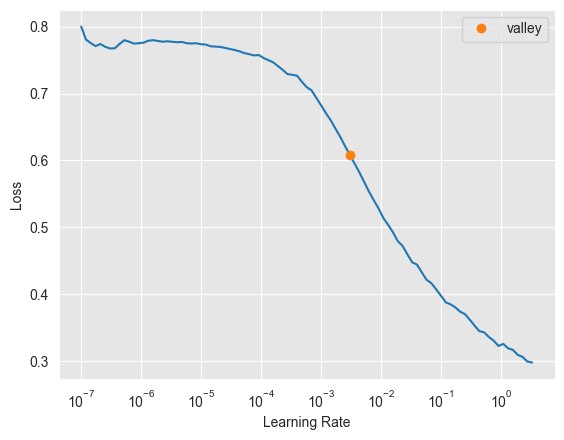

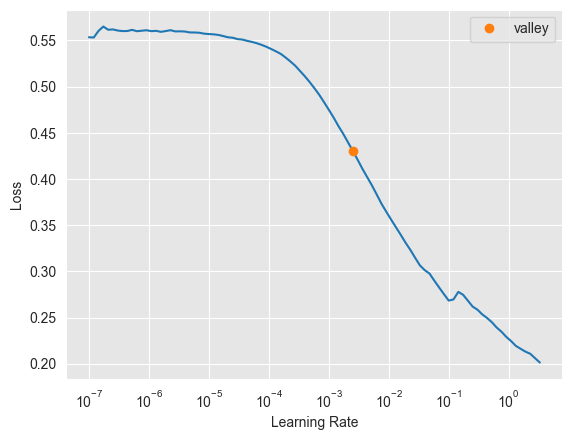

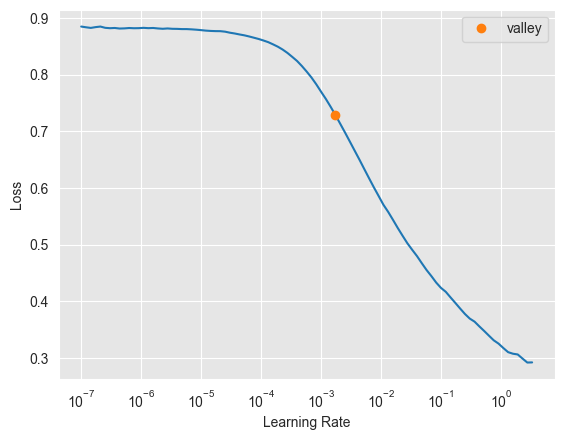

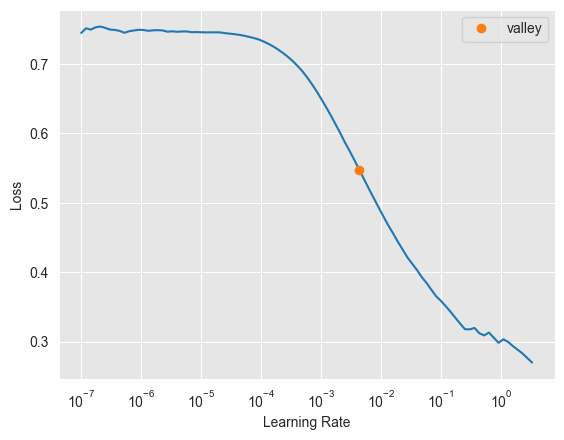

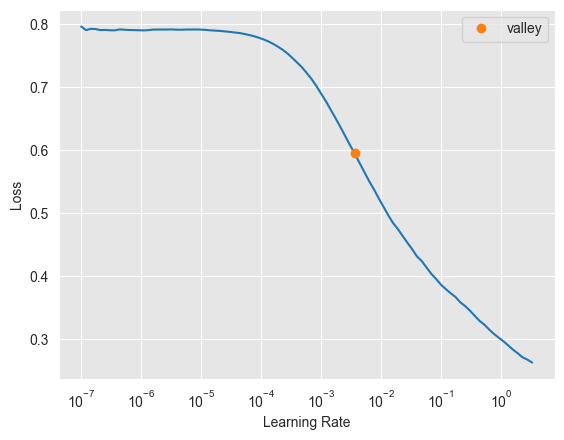

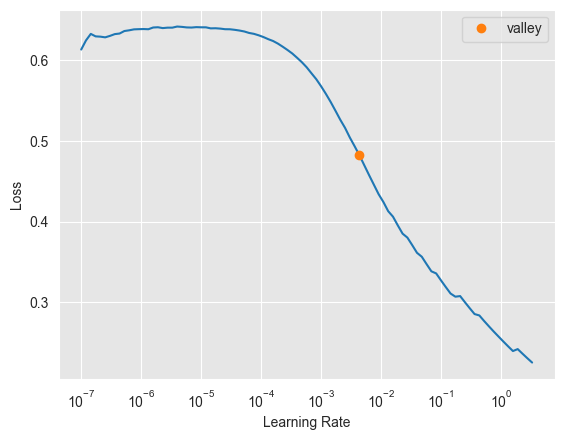

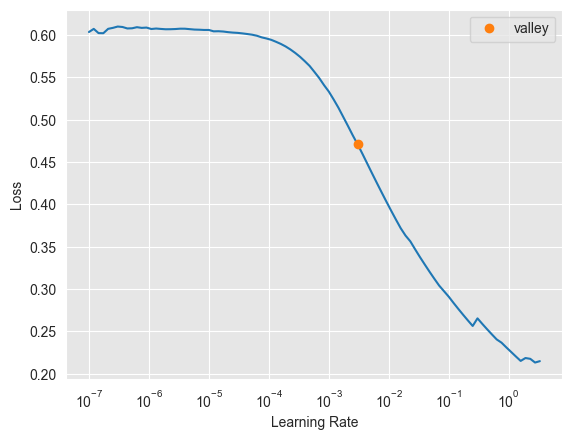

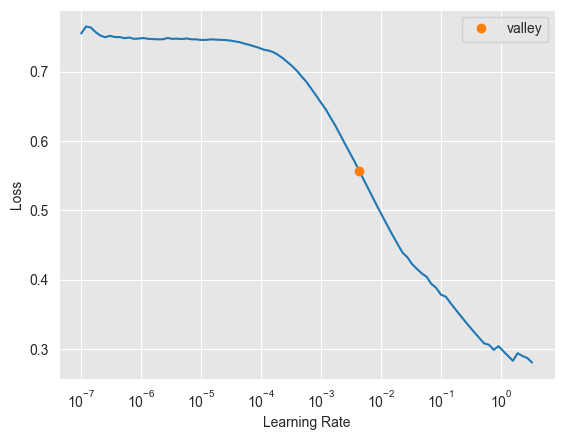

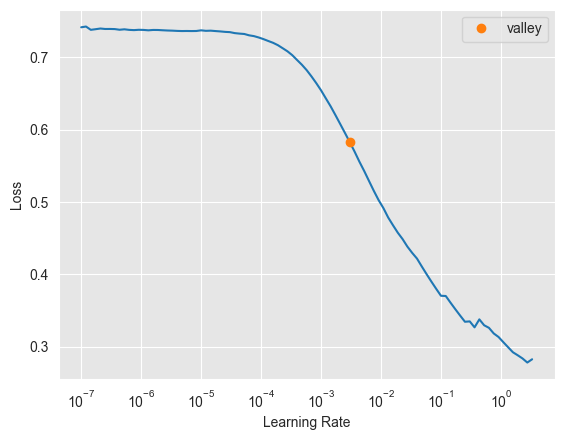

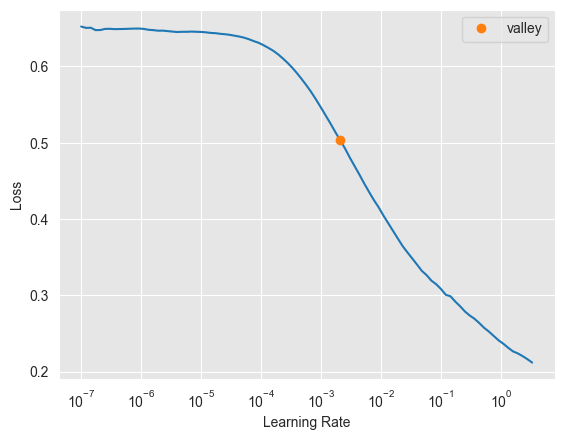

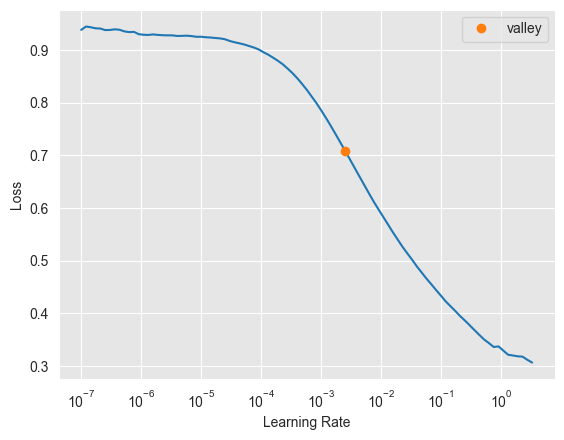

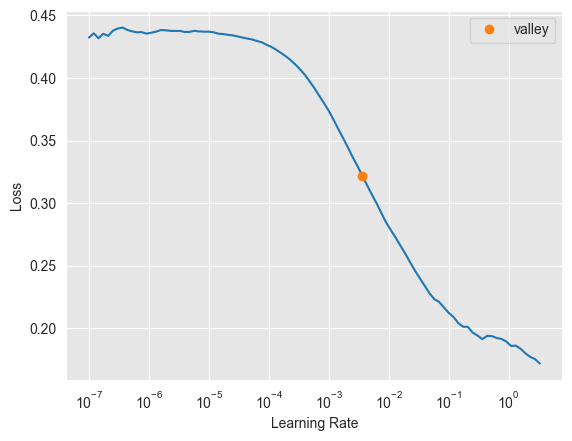

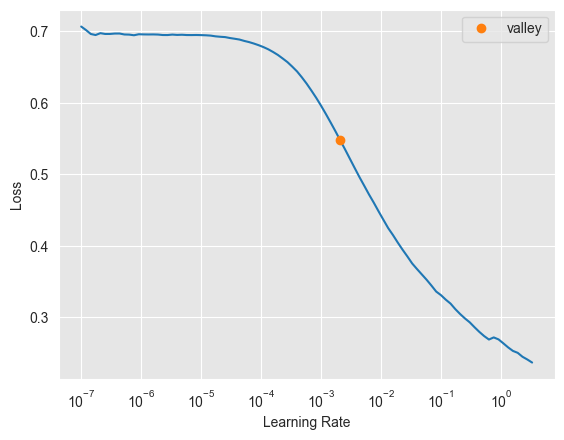

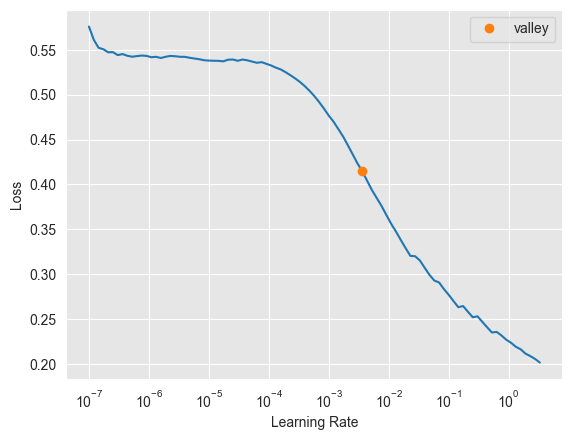

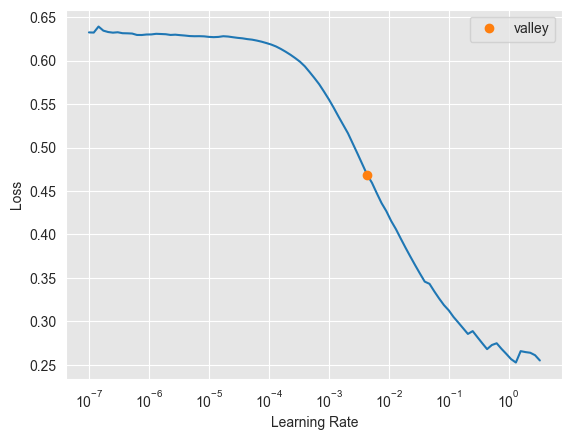

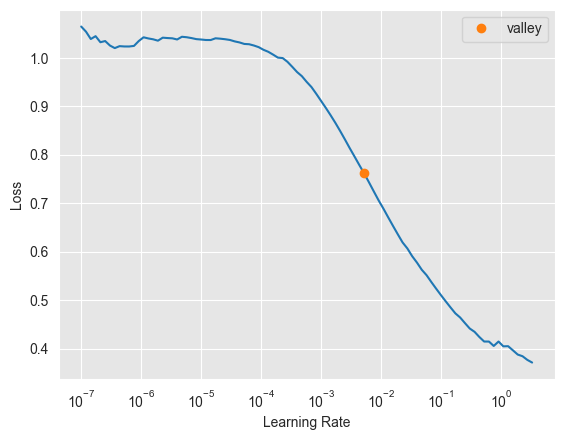

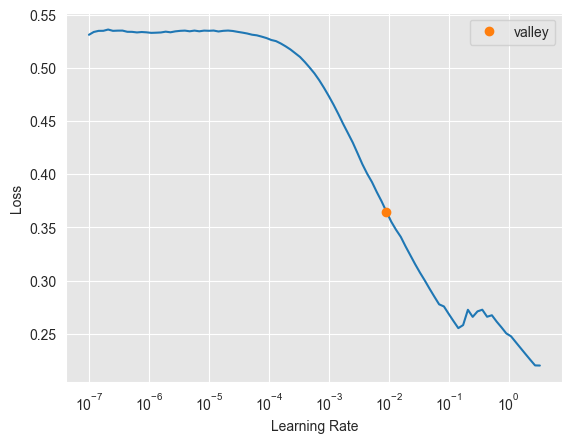

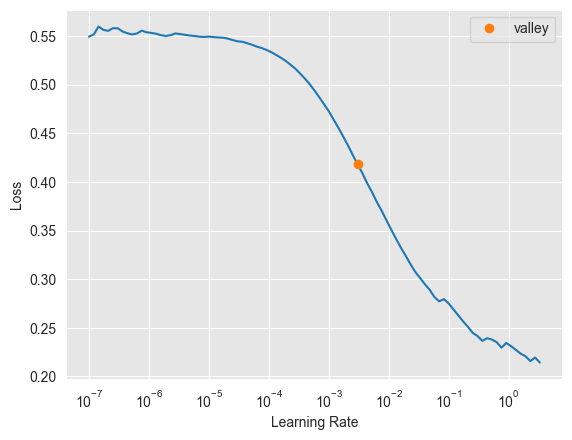

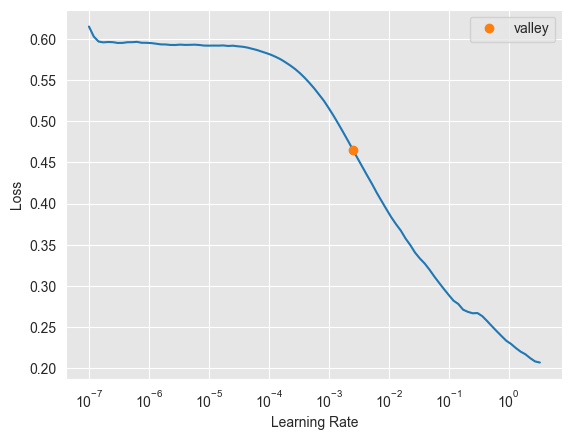

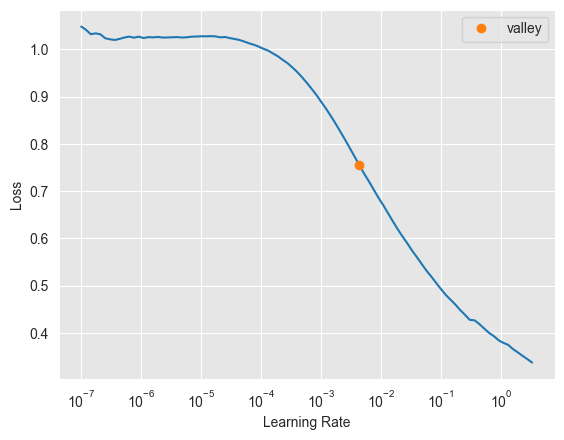

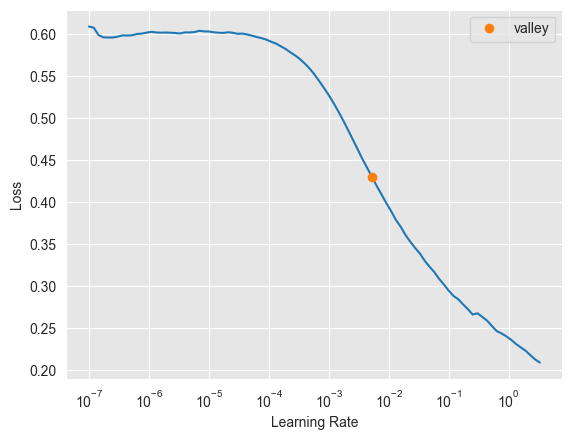

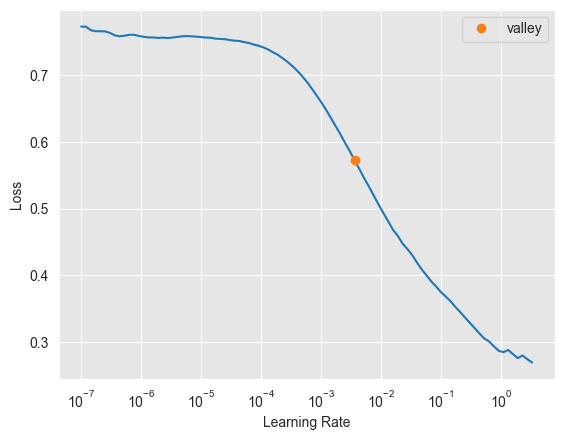

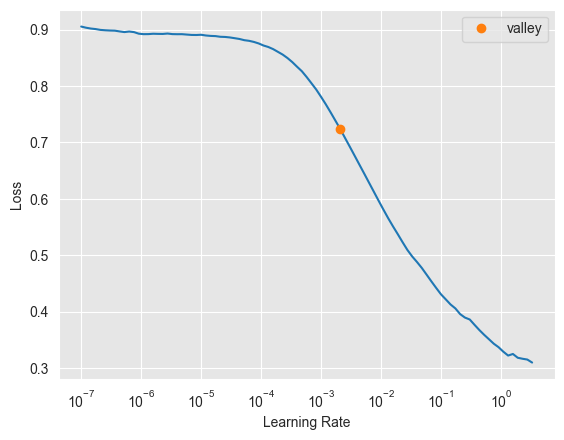

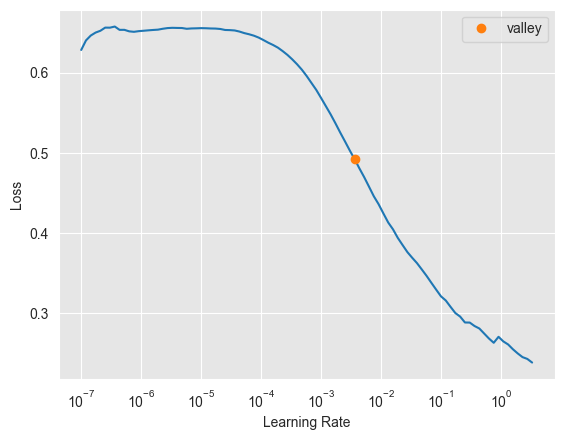

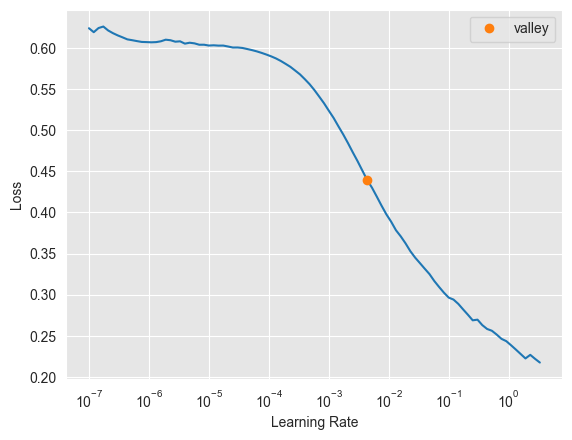

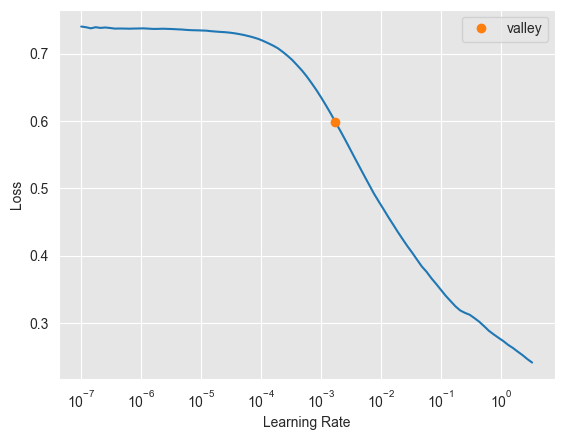

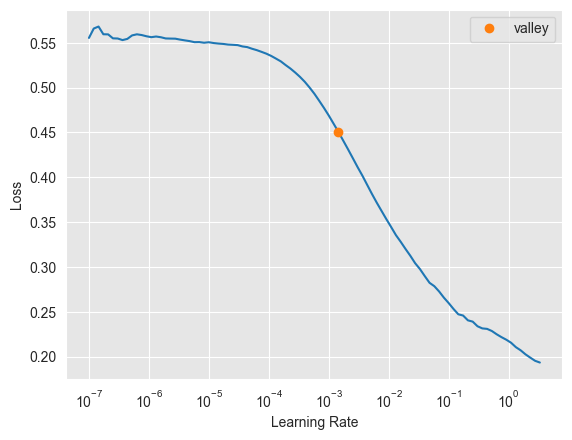

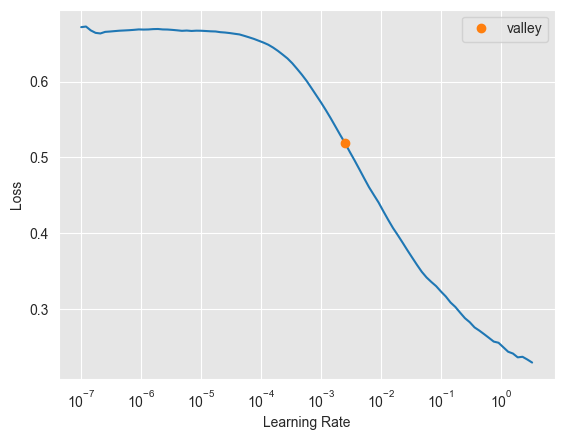

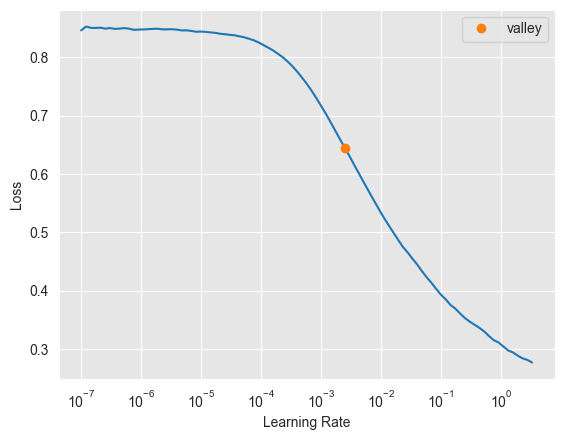

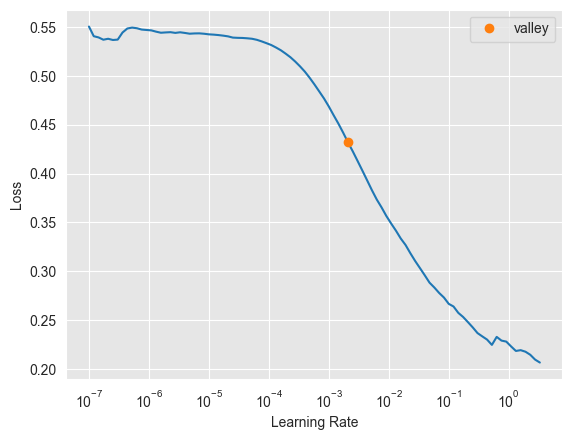

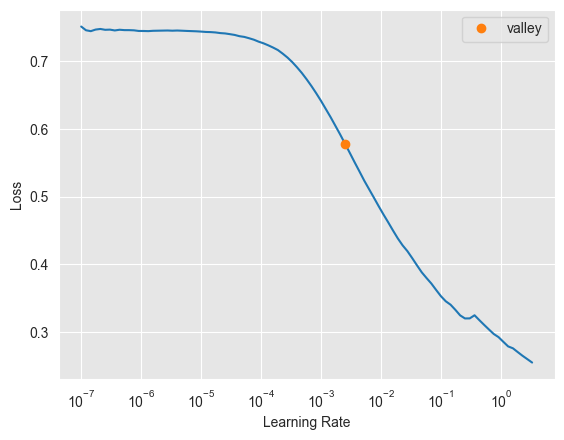

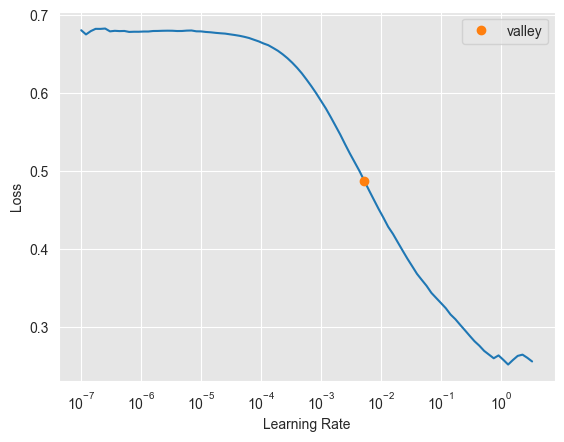

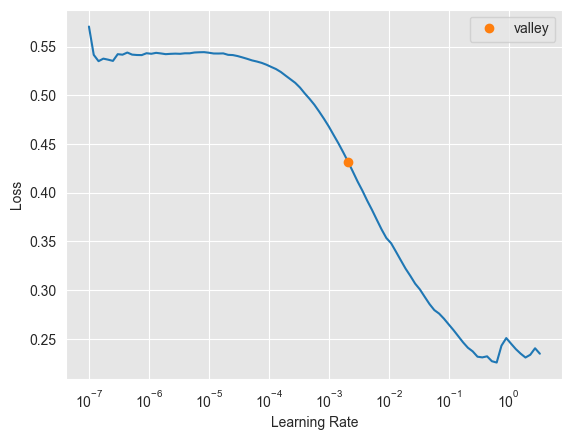

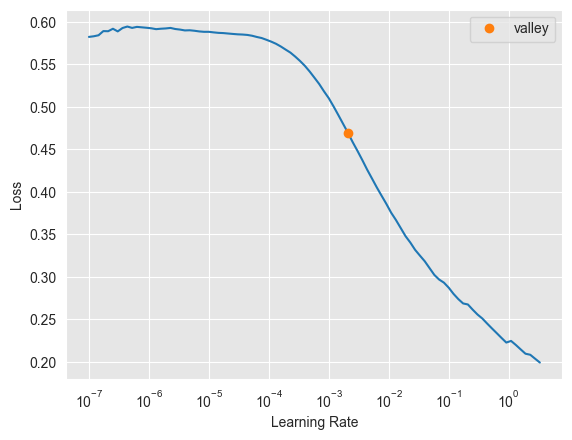

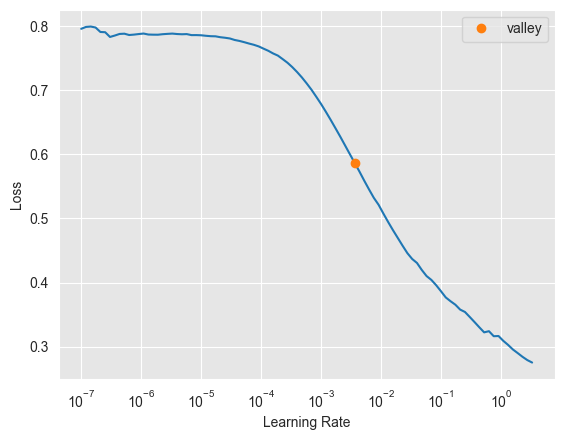

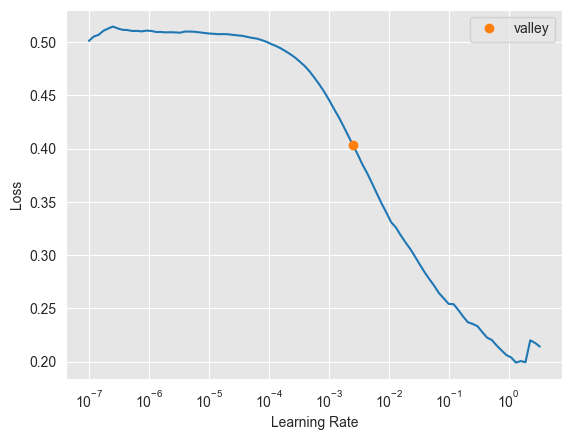

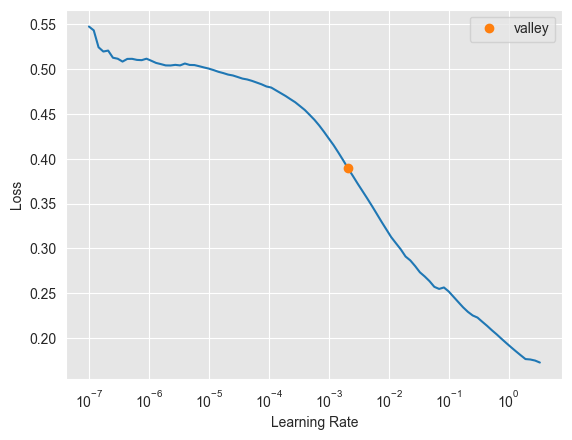

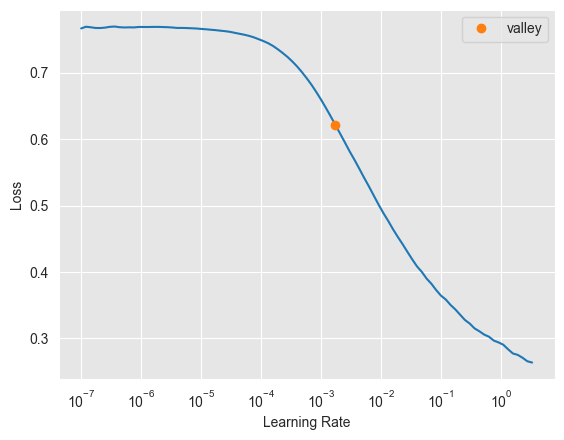

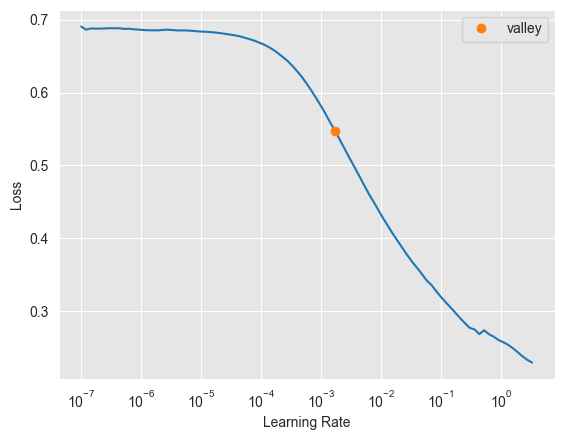

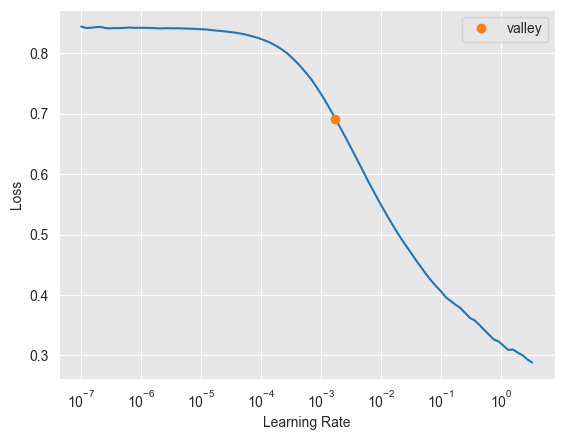

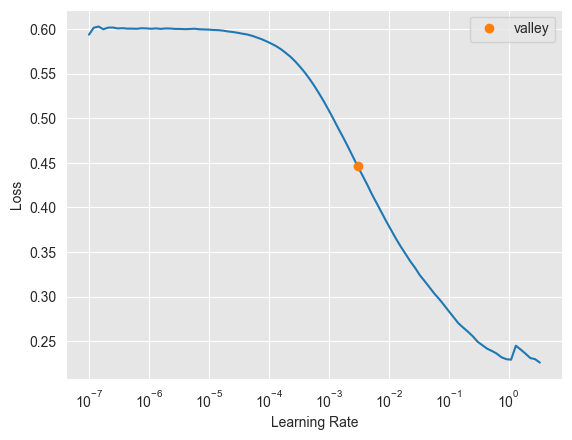

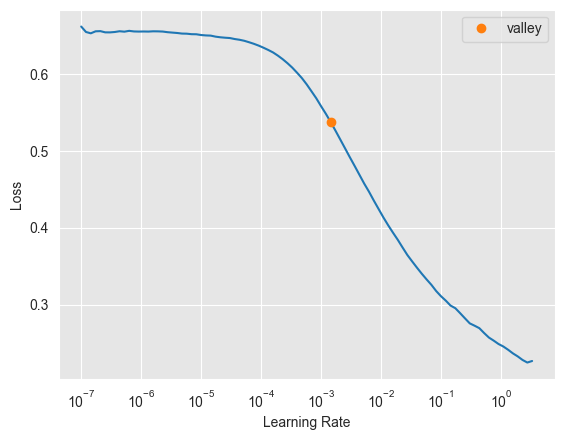

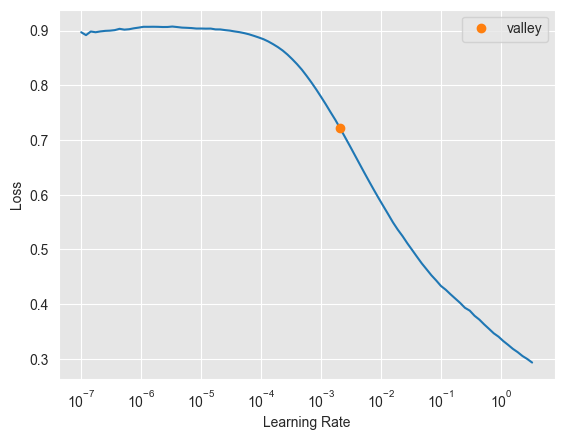

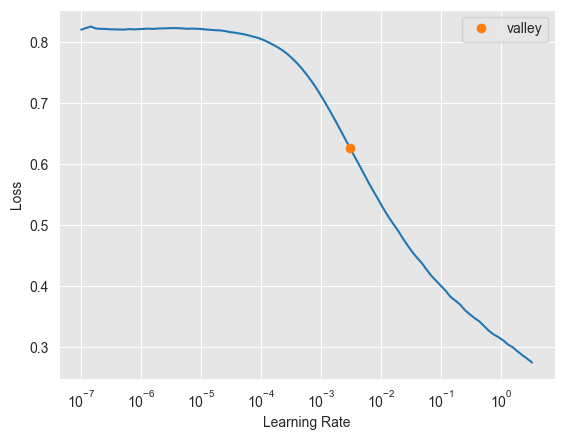

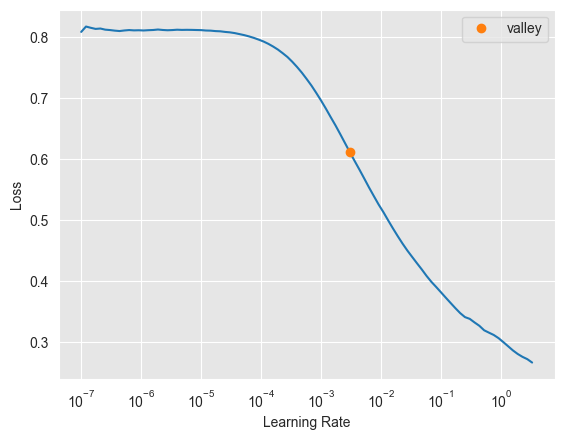

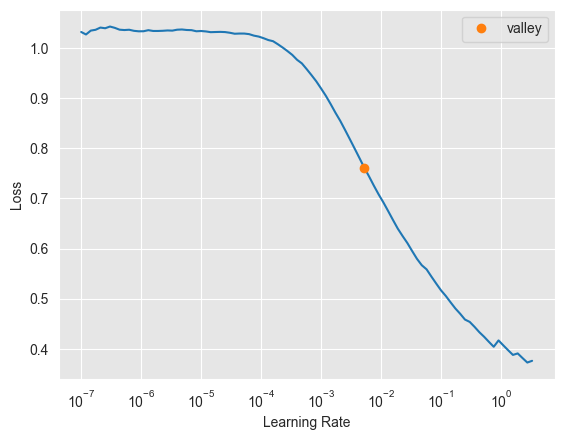

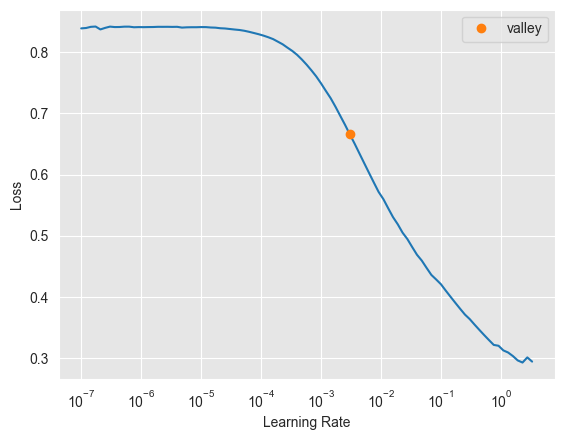

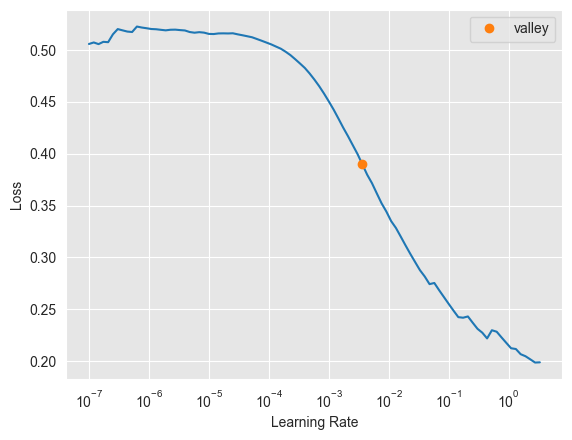

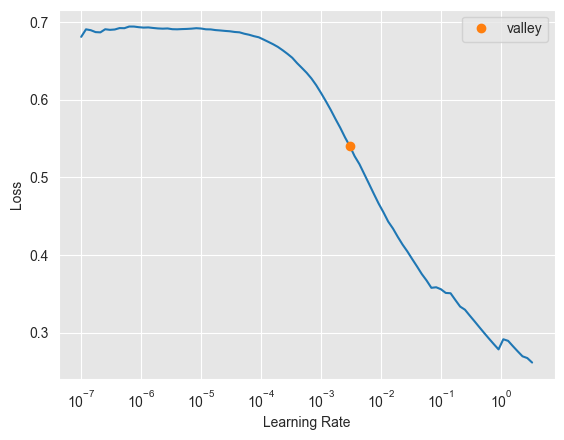

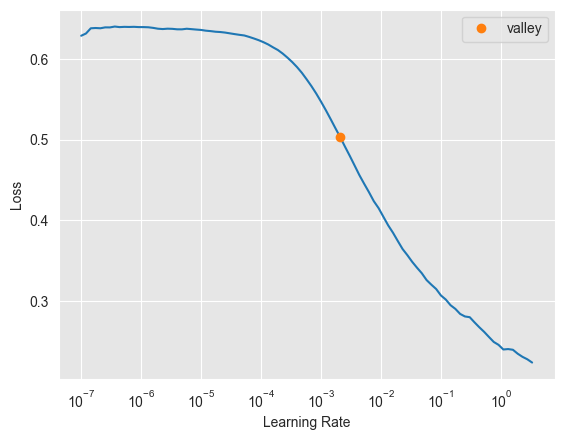

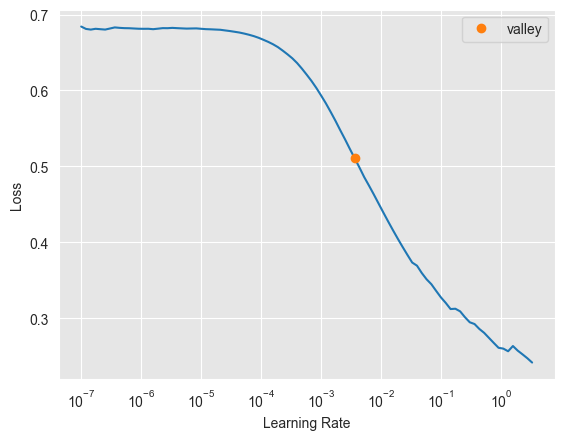

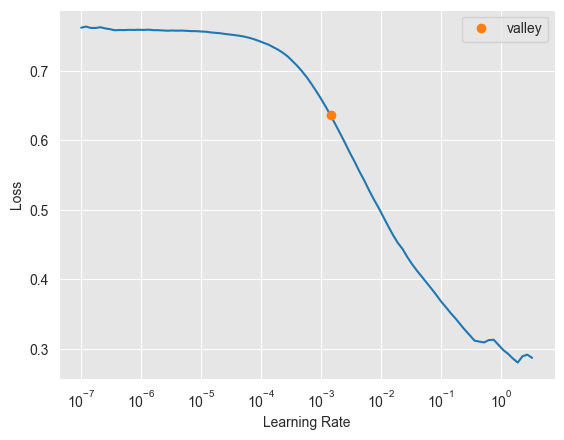

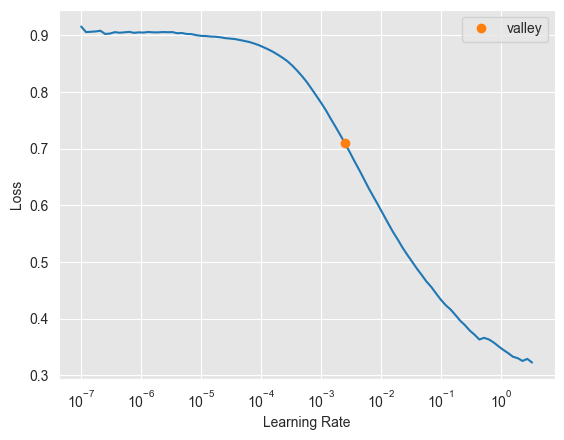

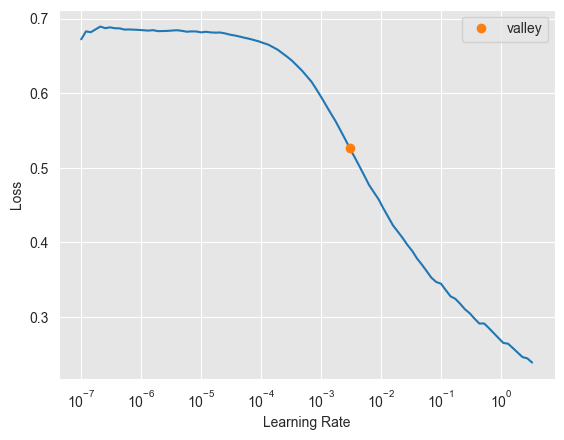

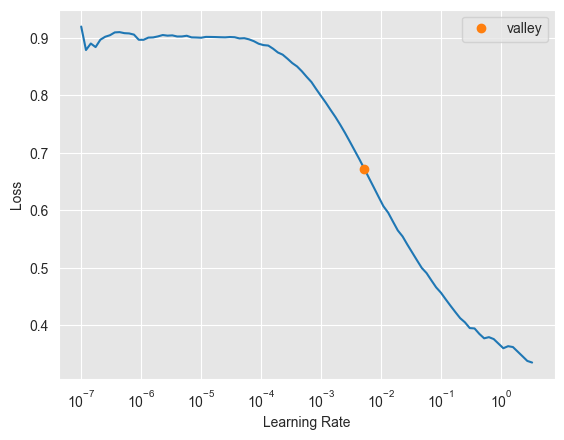

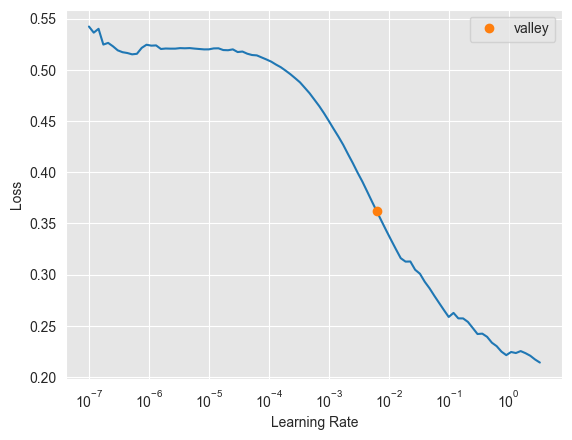

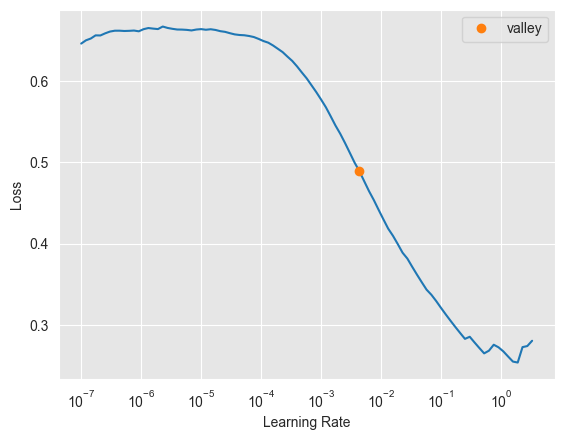

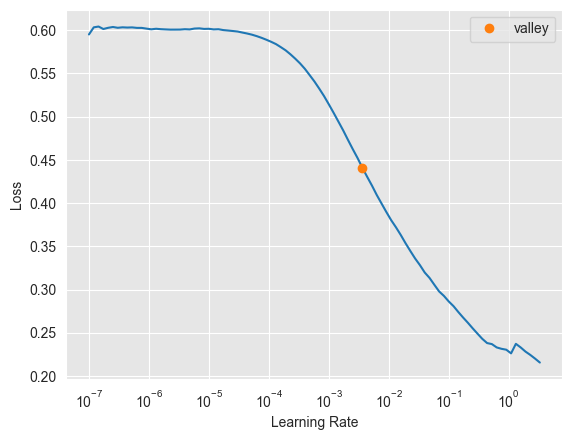

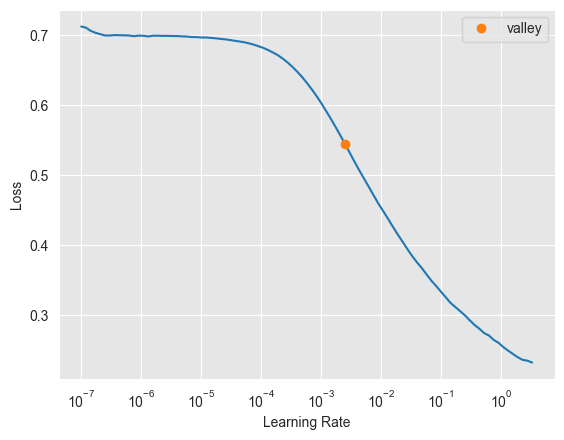

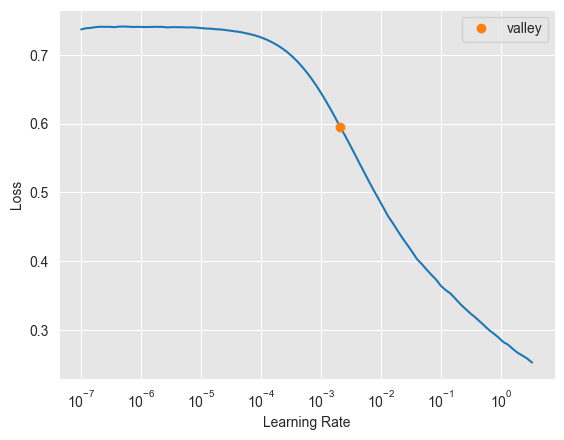

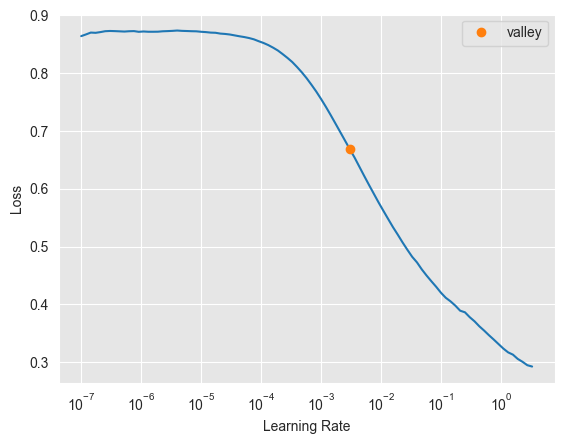

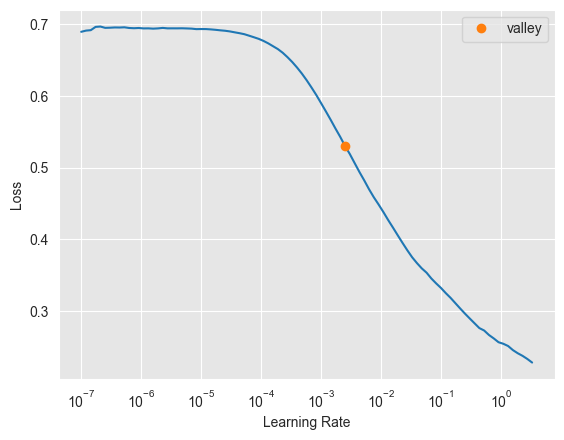

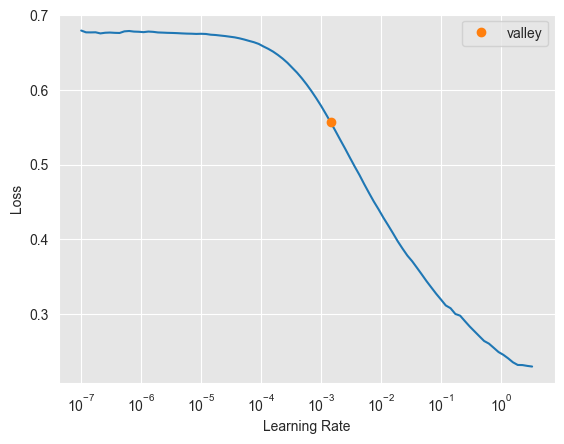

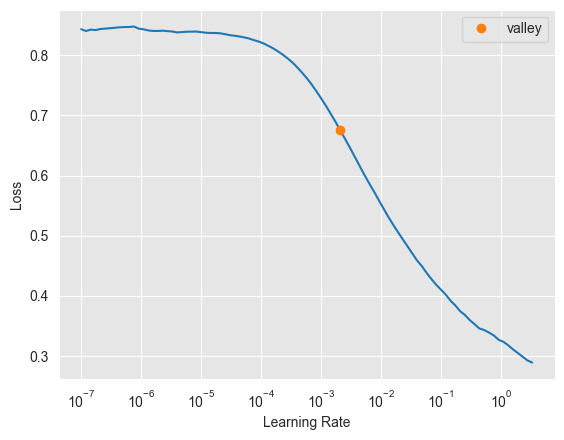

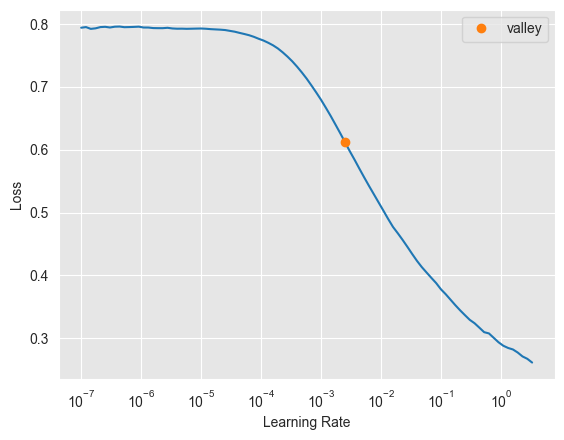

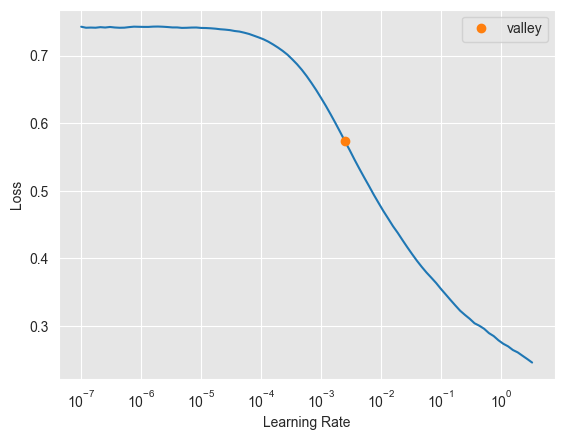

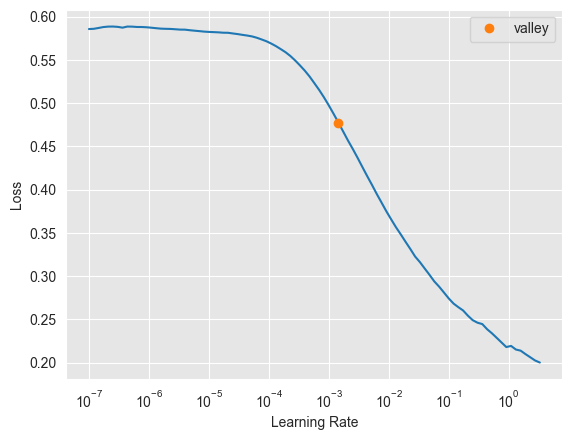

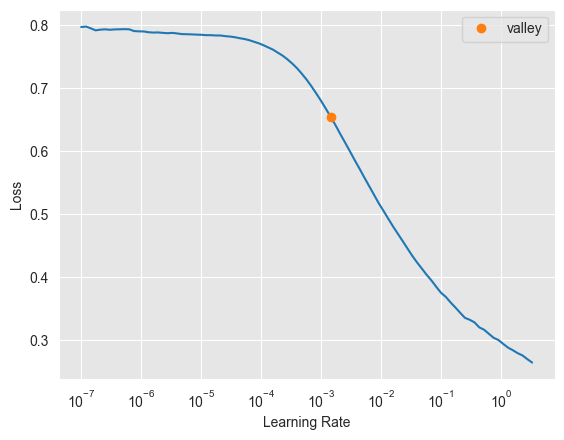

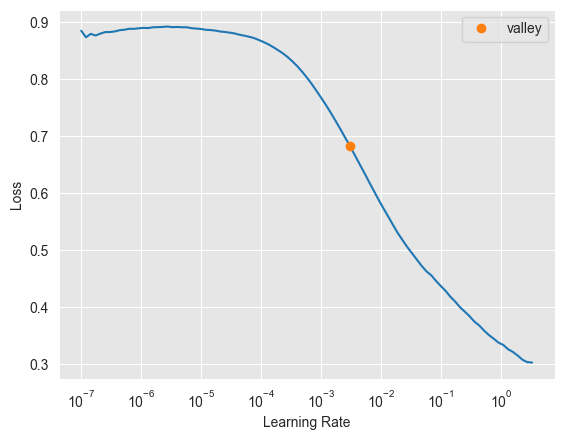

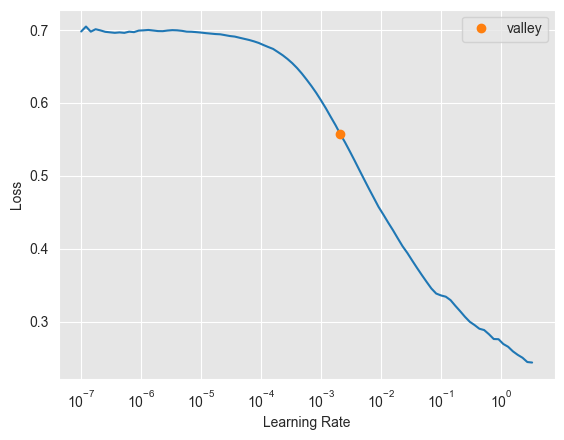

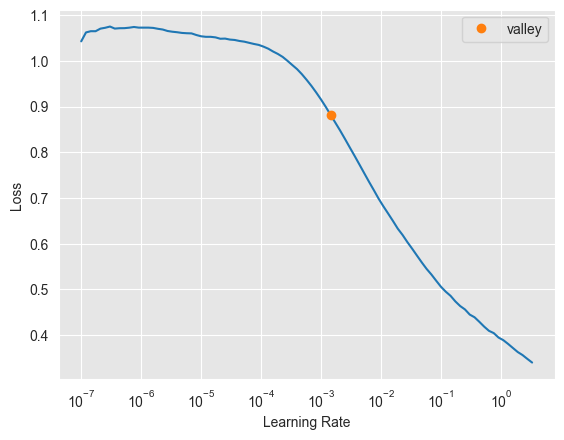

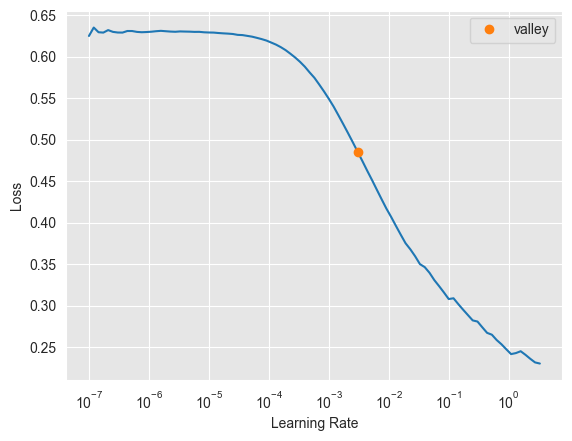

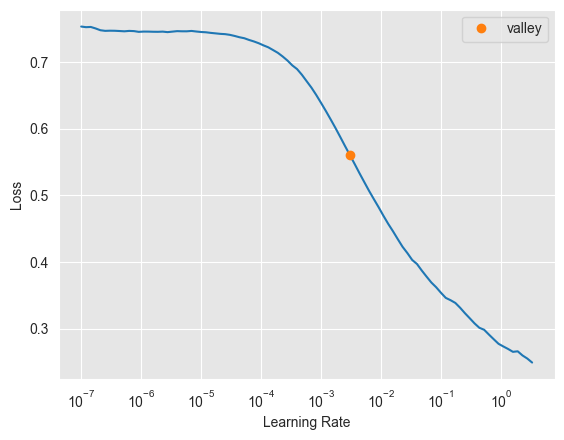

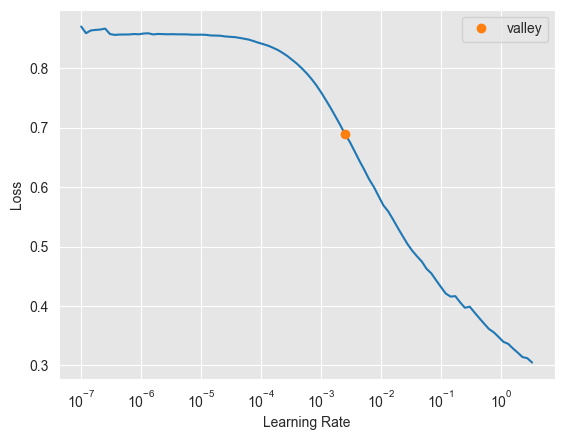

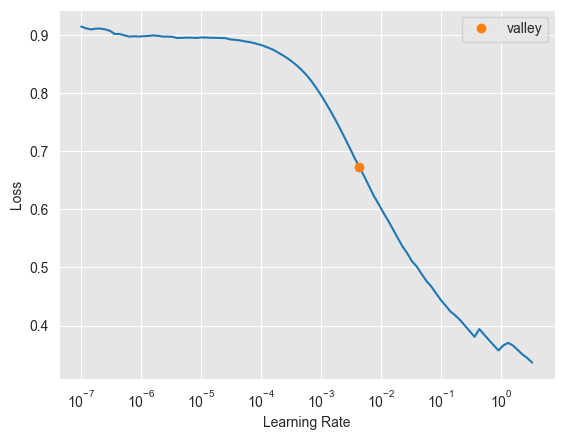

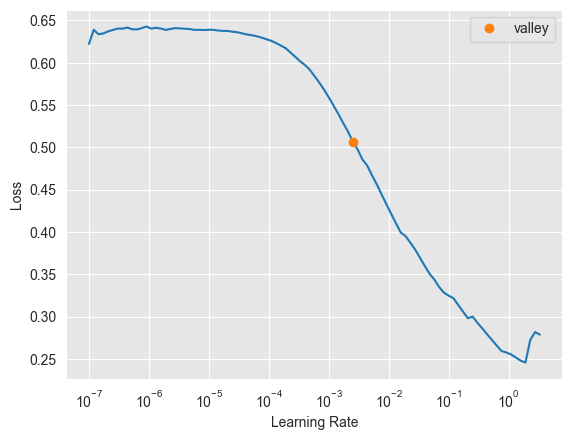

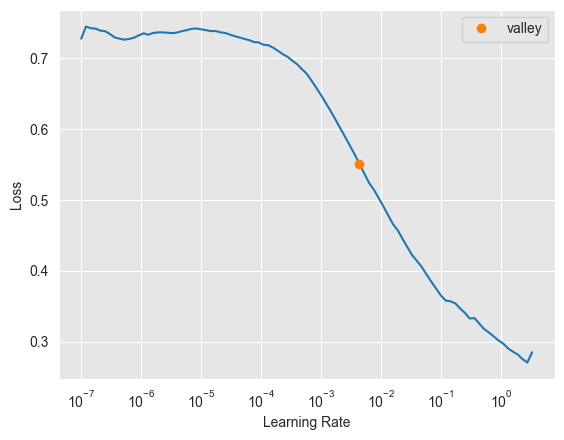

In [15]:
# only 24 possible combinations of hyperparameters
wandb.agent(sweep_id, train, count=24)